In [1]:
# TIME GAN

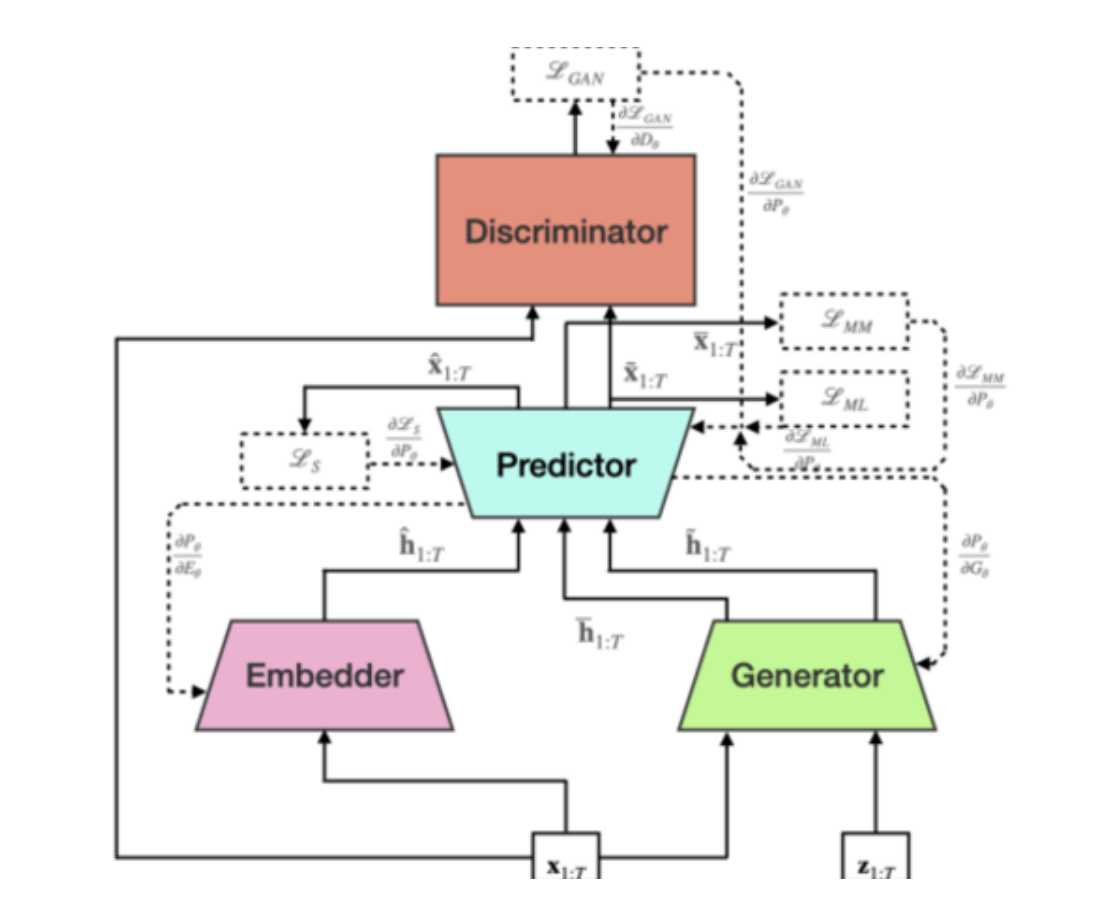

In [132]:
from IPython.display import Image
Image("Schema TsT-GAN.png", width=700, height=700)

In [57]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertModel, BertConfig, BertForMaskedLM


'''
    Given that x[1:T] denotes a true time-series of length T and z[1:T] denotes a sequence of random vectors drawn from an isotropic Gaussian, we provide formal motivation for our model, with an accompanying block diagram in Figure 1.

    The embedder, trained using maximum likelihood estimation (MLE) takes as input x1:T and produces conditional latent embeddings hˆ[1:T] which the predictor maps to values xˆ1:T.

    The generator takes as input a sequence of random vectors z1:T and produces a corresponding set of latent embeddings h˜[1:T]. 
    To maximise the downstream utility of synthetic data, the generator aims to learn the conditional latent distribution produced by the embedder such that ph~. 
    We achieve this by sharing predictor parameters between the generator and discriminator, but allowing the predictor’s parameters to be changed only when updating with respect to the gradient ∂LS/∂Pθ , thereby forcing the condition.

    The discriminator is tasked with differentiating between real sequences x1:T and synthetic sequences x˜[1:T] . 
    The discriminator operates over entire sequences, producing only one true/false classification and so, inspects synthetic sequences on a global scale and encourages the generator to learn the joint distribution of entire sequences. 
    The objective LMM reinforces this by while also exposing the generator to real samples and further encouraging bidirectional learning of the joint distribution. 
    Some approaches to time-series generation have shown that explicit moment matching can improve the quality of synthetic data. We introduce an auxiliary moment loss to promote matching of first and second moments:
    
    where fµ and fσ are functions that compute the mean and standard deviation of a time-series.
    
    dim_val = 32
    hum_heads = 8
    hidden_dim = 4 * d = 128
    hum_layers = 3
    activation = GELU
    normalisation = LayerNorm
    
    optimisator = Adam
    LR1 = 0.001 for embedder-predictor and generator
    LR2 = 0.00002 
    beta1 = 0.5, beta2 = 0.999
    pmask = 0.3
    batch_size = 128
    
'''


class Embedder(nn.Module):
    '''
        The embedder–predictor network consists of a transformer network that takes as input real multivariate sequences x[1:T] and predicts the next item in the sequence at each position.
        This network consists of a linear projection of the input vector into the model dimension. 
        The projected sequence is passed through the embedder network Eθ to produce the set of final embeddings h[1:T]
        Эмбеддер формирует скрытые состояния и передает их на вход сети Предиктора. 
        Эмбеддер - дектодер трансформера
        Позиционное кодирование - синус ( заменить на тренируемое? )
        
        ??? Использует авторегрессионную маску ???
        
        Input: 
            x: real data B x S x F
                where B - Batch Size, S - sequence length, F - nums of features
        Output:
            out: hidden state B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension
        
        Loss: Ls = 1/T-1 * СУММА(||х[t+1] - x^t||2) - евклидово расстояние между реальными данными и прогнозом на t+1 шаг (torch.nn.PairwiseDistance(p=2))
    '''
    def __init__(self, input_dim, d_model, num_layers, num_heads, hidden_dim):
        super(Embedder, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        
        self.resize_F_H = nn.Linear(self.input_dim, self.d_model)
        
        self.embedder_config = BertConfig(hidden_size=self.d_model, 
                                           num_hidden_layers=self.num_layers,
                                           num_attention_heads=self.num_heads,
                                           intermediate_size=self.hidden_dim,
                                           position_embedding_type='relative_key_query',
                                           # is_decoder=True
                                          )
        self.embedder = BertModel(self.embedder_config)
        
    def forward(self, x):
        x = self.resize_F_H(x)
        
        out = self.embedder(inputs_embeds=x, return_dict=False)[0]
        
        return out
        
        
class Predictor(nn.Module):
    '''
        The predictor network Pθ takes the embeddings back into the original input dimension Pθ : Rd → R m and is implemented by a separate neural network.
        Предиктор получает от сети Эмбеддер скрытые состояния и предсказывает значения для t+1 шага для t[1:T] 
        Предиктор - простая линейная сеть, которая из размерности H переводит последовательность в размерность F
        
        Input: 
            x: latent space B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension embedder network
        Output:
            out: recovery real data B x S x F
                where B - Batch Size, S - sequence length, F - nums of features

        Loss: Ls = 1/T-1 * sum(||х[t+1] - x^t||2) - евклидово расстояние между реальными данными и прогнозом на t+1 шаг (torch.nn.PairwiseDistance(p=2))
            auxiliary loss:
                Lml = |mu(x) - mu(x~)| + |sigma(x) - sigma(x~)|
    '''
    def __init__(self, d_model, output_dim):
        super(Predictor, self).__init__()
        self.d_model = d_model
        self.output_dim = output_dim
        
        self.resize_H_F = nn.Sequential(nn.LayerNorm(self.d_model),
                                        nn.Linear(self.d_model, self.d_model//2),
                                        nn.ReLU(),
                                        nn.Linear(self.d_model//2, self.output_dim))
        
    def forward(self, x):
        out = self.resize_H_F(x)
        
        return out
        
        

class Generator(nn.Module):
    '''
        The generator model Gθ takes a sequence of random vectors z[1:T] and projects these into the model dimension. 
        The projected noise vector is passed through Gθ which outputs a set of latent embeddings h[1:T]
        Each latent embedding h is then transformed back into the original input space by way of the predictor network from Section 3.2.1 to produce a synthetic sequence x˜[1:T]. 
        Parameters of the predictor network are shared between the generator and embedder.
        We construct Gθ in a similar way to the embedding network; it consists of a transformer encoder that makes use of bidirectional attention.
        To enforce the autoregressive property, we allow the parameters of the predictor network to be updated only when performing backpropagation through the embedder–predictor network. 
        When backpropagating through the generator-predictor network, gradients are calculated but the parameters of the predictor network are frozen. 
        This forces the generator to learn the latent conditional distributions of the embedder to produce valid synthetic data while also allowing full treatment of the joint probability. 
        The random vectors fed into the generator can be drawn from any distribution, we draw random vectors from a standard Gaussian distribution.
        
        Генератор из шума формирует последовтельность размерности скрытого состояния, прям как Эмбеддер, и отправляет в Предиктор. 
        При обновлении весов генератора Предиктор замораживается, что побуждает Генератор синтезировать корректные скрытые представления
        Позиционное кодирование - синус ( заменить на тренируемое? )

        ??? Генератор - энкодер трансформера ???
        ??? Генератор использует двунаправленное внимание ???
        
        ????? Генератор маскируется и попеременно обучается на максированных данных и исходных ?????
        
        Input: 
            x: noise B x S x Z
                where B - Batch Size, S - sequence length, Z - noise dimension
        Output:
            out: hidden state B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension
                
        Loss: Lgan(G) = min 1/2 (D(Xf) - 1) ^ 2 - MSE на фейковых данных и 1 как класс
            loss masking model:
              Lmm = 1/|M| sum (xt - x~t) ^ 2 - дополнительно MSE для максированных x последовательности
    '''
    def __init__(self, latent_noise_dim, input_dim, d_model, num_layers, num_heads, hidden_dim):
        super(Generator, self).__init__()
        self.latent_noise_dim = latent_noise_dim
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.p = 0.3
        
        self.resize_Z_H = nn.Linear(self.latent_noise_dim, self.d_model)
        self.resize_F_H = nn.Linear(self.input_dim, self.d_model)
        
        self.generator_config = BertConfig(hidden_size=self.d_model, 
                                           num_hidden_layers=self.num_layers,
                                           num_attention_heads=self.num_heads,
                                           intermediate_size=self.hidden_dim,
                                           position_embedding_type='relative_key_query',
                                           output_hidden_states=True)
        self.generator = BertForMaskedLM(self.generator_config)
        
    def forward(self, x, masking=False):
        
        if masking:
            x = self.resize_F_H(x)
            b = x.shape[0]
            mask = []

            ones = int(x.shape[1]*0.3)
            zeros = x.shape[1] - ones

            for _ in range(b):
                m = torch.cat((torch.zeros(zeros), torch.ones(ones)))
                m = m[torch.randperm(m.shape[0])]
                m = m.view(-1)
                mask.append(m * -100)

            mask = torch.vstack(mask).long()
            out = self.generator(inputs_embeds=x, return_dict=False, labels=mask)[2][-1] 
            return out, mask
        else:
            x = self.resize_Z_H(x)
            out = self.generator(inputs_embeds=x, return_dict=False)[1][-1]
        
            return out

class Discriminator(nn.Module):
    '''
       The discriminator model Dθ is constructed in a similar way to BERT as a transformer encoder with bidirectional attention. 
       A linear projection is used to map input sequences to the model dimension following which a [CLS] embedding is prepended to the beginning of the sequence. 
       This sequence is passed through the discriminator and the embedding corresponding to the [CLS] position is projected into R1 for classification. 
       The discriminator receives as input real sequences drawn from the dataset, which it is tasked with classifying as true, and synthetic sequences from the generator, which it must classify as false. 
       Our discriminator design focuses on a global classification of the quality of a sequence, which differs from previous RNN based approaches which classify on a per time step basis.
       By performing global sequence classification with the discriminator, we address our first objective in Equation 1, while the stepwise objective in Equation 2 is handled indirectly via the embedder–predictor system. 
       We apply the LS-GAN adversarial loss, which uses separate objectives for the discriminator and generator:
       
       Дискриминатор BERT like, при этом это энкодер трансформера с двунаправленным вниманием
       Позиционное кодирование - синус ( заменить на тренируемое? )
       
        
       Input: 
            x: noise B x S x Z
                where B - Batch Size, S - sequence length, Z - noise dimension
        Output:
            out: hidden state B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension
                   
        Loss: Lgan(D) = min((D(Xr)-1) ^ 2 + D(Xf) ^ 2)
    '''
    def __init__(self, input_dim, d_model, num_layers, num_heads, hidden_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        
        self.resize_F_H = nn.Linear(self.input_dim, self.d_model)
        
        self.generator_config = BertConfig(hidden_size=self.d_model, 
                                           num_hidden_layers=self.num_layers,
                                           num_attention_heads=self.num_heads,
                                           intermediate_size=self.hidden_dim,
                                           position_embedding_type='relative_key_query'
                                          )
        self.generator = BertModel(self.generator_config)
        
        self.get_proba = nn.Sequential(nn.Flatten(),
                                       nn.Linear(self.d_model, self.output_dim),
                                       )
        
    def forward(self, x):
        x = self.resize_F_H(x)
        out = self.generator(inputs_embeds=x, return_dict=False)[1]
        
        out = self.get_proba(torch.atanh(out))
        
        return out

In [61]:
class TsTGAN:
    def __init__(self, device, input_dim, latent_noise_dim, d_model, num_layers, num_heads, hidden_dim, start_lr, main_lr):
        super(TsTGAN, self).__init__()
        self.device = device 
        self.input_dim = input_dim
        self.latent_noise_dim = latent_noise_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.start_lr = start_lr
        self.main_lr = main_lr
        self.stage = 'start'
        
        self.embedder = Embedder(input_dim=self.input_dim, d_model=self.d_model, num_layers=self.num_layers, num_heads=self.num_heads, hidden_dim=self.hidden_dim)
        self.predictor = Predictor(d_model=self.d_model, num_layers=self.num_layers, num_heads=self.num_heads, hidden_dim=self.hidden_dim, output_dim=self.input_dim)
        self.generator = Generator(latent_noise_dim=self.latent_noise_dim, input_dim=self.input_dim, d_model=self.d_model * 2, num_layers=self.num_layers + 1, num_heads=self.num_heads, hidden_dim=self.hidden_dim * 2)
        self.discriminator = Discriminator(input_dim=self.input_dim, d_model=self.d_model, num_layers=self.num_layers, num_heads=self.num_heads, hidden_dim=self.hidden_dim)
        
        print(f'Embedder total params: {sum([i.numel() for i in self.embedder.parameters()])}')
        print(f'Predictor total params: {sum([i.numel() for i in self.predictor.parameters()])}')
        print(f'Generator total params: {sum([i.numel() for i in self.generator.parameters()])}')
        print(f'Discriminator total params: {sum([i.numel() for i in self.discriminator.parameters()])}')
        
        self.criterion_S = nn.PairwiseDistance(p=2)
        self.criterion_GAN = nn.MSELoss()
        self.criterion_MM = nn.PairwiseDistance(p=2)
        self.criterion_ML = nn.L1Loss()
        
        self.optimizer_E = torch.optim.Adam(self.embedder.parameters(), lr=self.start_lr)
        self.optimizer_P = torch.optim.Adam(self.predictor.parameters(), lr=self.start_lr)
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.start_lr)
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.main_lr)
        
    
    def _init_weight(self):
        pass
    
    
    def _freeze_network(self, model):
        model.eval()
        for param in model.parameters():
            param.requires_grad = False
        return model
    
    def _unfreeze_network(self, model):
        model.train()
        for param in model.parameters():
            param.requires_grad = True
        return model
    
    def to_main(self):
        self.optimizer_E = torch.optim.Adam(self.embedder.parameters(), lr=self.main_lr, betas=(0.5, 0.999))
        self.optimizer_P = torch.optim.Adam(self.predictor.parameters(), lr=self.main_lr, betas=(0.5, 0.999))
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.main_lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.main_lr, betas=(0.5, 0.999))
        self.stage = 'main'
    
        
    def visualisation(self, X_real, scaler):
        X_real = X_real[0, :, :]
        seq_len = X_real.shape[0]
        with torch.no_grad():
            Z = torch.FloatTensor(1, seq_len, self.latent_noise_dim).normal_(0, 1)
            X_fake = self.generator(Z)
            test_Xg = self.predictor(X_fake).squeeze(0)
            
            
        if scaler:
            test_Xg = scaler.inverse_transform(test_Xg)
            
        print(test_Xg.shape, X_real.shape)
        
        concat_X = np.concatenate((X_real.numpy(), test_Xg.numpy()), axis = 0)
        print(concat_X.shape)
        
        tsne = TSNE()
        _X_tsne = tsne.fit_transform(concat_X)
        
        colors = ["tab:blue" for i in range(seq_len)] + ["tab:orange" for i in range(seq_len)] 

        fig, axs = plt.subplots(2, 3, figsize=(27, 8))
        axs[0, 0].plot(range(test_Xg.shape[0]), test_Xg[:, 0], label = 'open')
        axs[0, 1].plot(range(test_Xg.shape[0]), test_Xg[:, 1], label = 'high')
        axs[0, 2].plot(range(test_Xg.shape[0]), test_Xg[:, 2], label = 'low')
        axs[1, 0].plot(range(test_Xg.shape[0]), test_Xg[:, 3], label = 'close')
        axs[1, 1].plot(range(test_Xg.shape[0]), test_Xg[:, 4], label = 'volume')

        
        axs[1, 2].scatter(_X_tsne[:seq_len,0], _X_tsne[:seq_len,1], c=colors[:seq_len], alpha = 0.2, label = "Original")
        axs[1, 2].scatter(_X_tsne[seq_len:,0], _X_tsne[seq_len:,1], c=colors[seq_len:], alpha = 0.2, label = "Synthetic")
        
        axs[0, 0].legend(loc='upper left')
        axs[0, 1].legend(loc='upper left')
        axs[0, 2].legend(loc='upper left')
        axs[1, 0].legend(loc='upper left')
        axs[1, 1].legend(loc='upper left')
        axs[1, 2].legend(loc='upper left')
        
        plt.show()
        
    def do_step(self, X_real):
        losses = []
        self.embedder = self._unfreeze_network(self.embedder)
        self.predictor = self._unfreeze_network(self.predictor)
        self.generator = self._unfreeze_network(self.generator)
        self.discriminator = self._unfreeze_network(self.discriminator)
        
        self.optimizer_E.zero_grad()
        self.optimizer_P.zero_grad()
        self.optimizer_G.zero_grad()
        self.optimizer_D.zero_grad()
        
        ### train Embedder and Predictor ###
        X_real_emb = self.embedder(X_real)
        x_cover = self.predictor(X_real_emb)
        loss_S = torch.sum(self.criterion_S(X_real[:, 1:, :], x_cover[:, :-1, :])) / (x_cover.shape[1] - 1)
        loss_S.backward()
        
        torch.nn.utils.clip_grad_norm_(self.embedder.parameters(), 5.)
        torch.nn.utils.clip_grad_norm_(self.predictor.parameters(), 5.)
        
        self.optimizer_E.step()
        self.optimizer_P.step()
        self.optimizer_E.zero_grad()
        self.optimizer_P.zero_grad()
        
        losses.append(loss_S.item())
        ### ============================ ###
        
        ### train masked Generator, Predictor frozen ###
        self.predictor = self._freeze_network(self.predictor)        
        X_real_masked, X_mask = self.generator(X_real, masking=True)
        x_dash = self.predictor(X_real_masked)
        loss_MM = torch.mean(self.criterion_MM(x_dash[X_mask.bool()], X_real[X_mask.bool()]))
        
        for param in self.generator.resize_Z_H.parameters():
            param.requires_grad = False
        
        loss_MM.backward()
        self.optimizer_P.zero_grad()
        torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 5.)
        self.optimizer_G.step()
        self.optimizer_G.zero_grad()
        
        for param in self.generator.resize_Z_H.parameters():
            param.requires_grad = True
            
        losses.append(loss_MM.item())
        ### ======================================== ###
        
        ### train 1', 2' moments Generator, Predictor frozen ###
        Z = torch.FloatTensor(*X_real.shape[:-1], self.latent_noise_dim).normal_(0, 1)
        X_fake = self.generator(Z)
        x_wave = self.predictor(X_fake)
        loss_ML = self.criterion_ML(X_real.mean(), x_wave.mean()) + self.criterion_ML(X_real.std(), x_wave.std())
        
        for param in self.generator.resize_F_H.parameters():
            param.requires_grad = False
        
        loss_ML.backward()
        self.optimizer_P.zero_grad()
        torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 5.)
        self.optimizer_G.step()
        self.optimizer_G.zero_grad()
        
        for param in self.generator.resize_F_H.parameters():
            param.requires_grad = True
        
        losses.append(loss_ML.item())
        ### ========================================= ###

        if self.stage=='main':         
            ### train Discriminator, Generator and Predictor frozen ###
            self.generator = self._freeze_network(self.generator)   
            
            y_real = torch.ones(X_real.shape[0], 1, dtype=torch.float).to(self.device)
            y_fake = torch.zeros(X_real.shape[0], 1, dtype=torch.float).to(self.device)
            
            D_out_real = self.discriminator(X_real)
            
            Z = torch.FloatTensor(*X_real.shape[:-1], self.latent_noise_dim).normal_(0, 1)
            X_fake = self.generator(Z).detach()
            x_wave = self.predictor(X_fake).detach()
            D_out_fake = self.discriminator(x_wave)
            
            loss_GAN_D = self.criterion_GAN(D_out_real, y_real) + self.criterion_GAN(D_out_fake, y_fake)
            
            loss_GAN_D.backward()
            self.optimizer_P.zero_grad()
            self.optimizer_G.zero_grad()
            torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 5.)
            self.optimizer_D.step()
            
            losses.append(loss_GAN_D.item())
            ### =================================================== ###
            
            ### train main Generator, Discriminator and Predictor frozen ###
            self.discriminator = self._freeze_network(self.discriminator)   
            self.generator = self._unfreeze_network(self.generator) 
            
            y_real = torch.ones(X_real.shape[0], 1, dtype=torch.float).to(self.device)
            Z = torch.FloatTensor(*X_real.shape[:-1], self.latent_noise_dim).normal_(0, 1)
            X_fake = self.generator(Z)
            x_wave = self.predictor(X_fake)
            D_out_fake = self.discriminator(x_wave)
            
            loss_GAN_G = self.criterion_GAN(D_out_fake, y_real) / 2
            
            loss_GAN_G.backward()
            self.optimizer_P.zero_grad()
            self.optimizer_D.zero_grad()
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 5.)
            self.optimizer_G.step()
            
            losses.append(loss_GAN_G.item())
            ### ======================================================== ###
        
        return losses
            
        

In [63]:
tst_gan = TsTGAN(device='cpu', input_dim=9, latent_noise_dim=9, d_model=128, num_layers=3, num_heads=8, hidden_dim=512, start_lr=1e-3, main_lr=2e-5)

Embedder total params: 4634576
Predictor total params: 4634457
Generator total params: 11337658
Discriminator total params: 4634705


In [767]:
losses = tst_gan.do_step(torch.FloatTensor(2, 471, 9).normal_(0, 1))

In [768]:
losses

[6.686262607574463, 3.4283154010772705, 0.4553055763244629]

In [769]:
tst_gan.to_main()

In [770]:
losses = tst_gan.do_step(torch.FloatTensor(2, 471, 9).normal_(0, 1))

In [771]:
losses

[6.244647026062012,
 2.553335428237915,
 0.3938746750354767,
 0.6221451163291931,
 0.38955795764923096]

torch.Size([471, 9]) torch.Size([471, 9])
(942, 9)


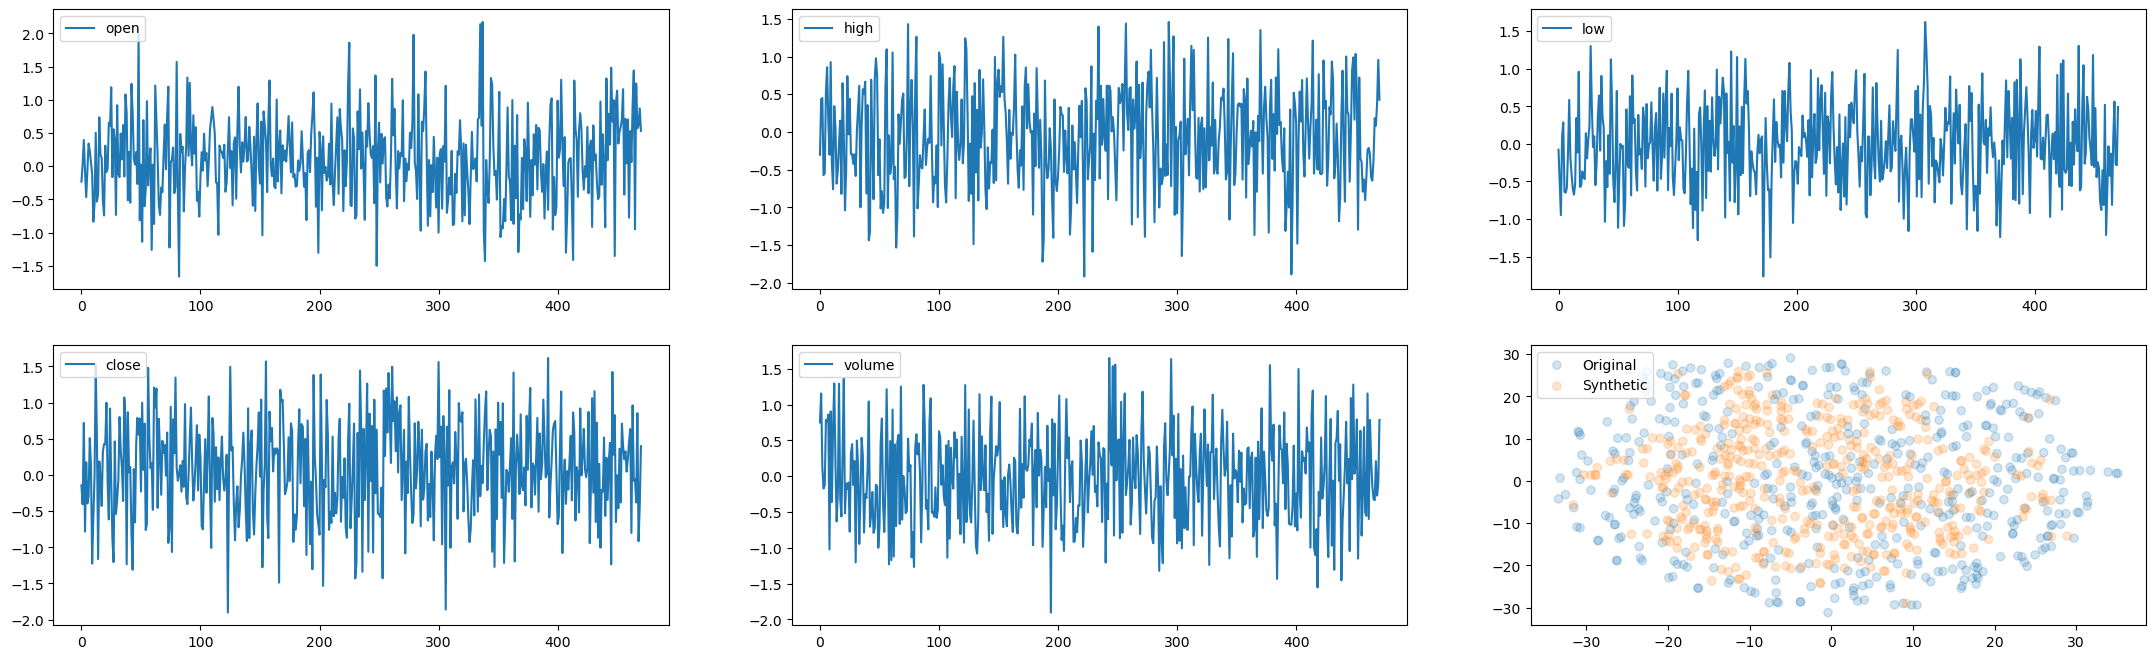

In [772]:
tst_gan.visualisation(torch.FloatTensor(2, 471, 9).normal_(0, 1), None)

In [149]:
df = pd.read_csv('gazp_df.csv', index_col=0)
df

,time,open,high,low,close,volume
0,2012-01-03 10:00:00,172.53,174.14,172.22,173.55,3200690
1,2012-01-03 11:00:00,173.58,173.71,173.41,173.61,2162150
2,2012-01-03 12:00:00,173.65,174.04,173.15,173.82,2347340
3,2012-01-03 13:00:00,173.77,174.03,173.34,173.62,1688080
4,2012-01-03 14:00:00,173.53,173.70,173.22,173.60,1294340
...,...,...,...,...,...,...
25310,2023-03-31 14:00:00,168.83,169.61,168.61,169.09,2727720
25311,2023-03-31 15:00:00,169.09,169.37,169.00,169.04,1188660
25312,2023-03-31 16:00:00,169.04,169.33,168.80,169.20,1383900
25313,2023-03-31 17:00:00,169.19,169.85,169.18,169.41,1946610


In [552]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE

In [340]:
class TimeseriesDataset(utils.data.Dataset): 
    def __init__(self, X_, y, seq_len, shift_len, addition_X_=None, addition_y=None):
        self.X = X_
        self.y = y
        self.seq_len = seq_len
        self.shift_len = -shift_len 
        self.addition_X_ = addition_X_
        self.addition_y = addition_y


    def __len__(self):
        return self.X.shape[0] - self.seq_len - self.shift_len

    def __getitem__(self, index):
        total_X = [self.addition_X_, self.X] if self.addition_X_ is not None and self.addition_y is not None else [self.X]
        total_y = [self.addition_y, self.y] if self.addition_X_ is not None and self.addition_y is not None else [self.y]
        Xs = [X[index: index + self.seq_len] for X in total_X]
        ys = [y[index + self.seq_len - self.shift_len: index + self.seq_len] for y in total_y]

        return list(zip(Xs, ys))

In [555]:
main_data = df.copy()
main_data['label_seq'] = 1

loaders = []

for idx_slc, [slc_train, _] in enumerate([[0.5, 0.52]]):
    train_df = main_data.iloc[:int(main_data.shape[0]*slc_train), :] if idx_slc == 0 else main_data.iloc[max(0, int(main_data.shape[0]*slc_train)-int(6144)): int(main_data.shape[0]*slc_train), :]
    X_train = train_df.iloc[:, 1:-1]
    y_train = train_df.iloc[:, -1]

    # test_df = main_data.iloc[int(main_data.shape[0]*slc_train) - seq_len: int(main_data.shape[0]*slc_test), :]
    # X_test = test_df.iloc[:, 1:-1]
    # y_test = test_df.iloc[:, -1]

    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = RobustScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    # X_train = X_train.values

    train_dataset = TimeseriesDataset(torch.tensor(X_train.astype(np.float32)), 
                                      torch.tensor(y_train.to_numpy().astype(np.float32)), 
                                      seq_len=120,
                                      shift_len=0
                                      )
    train_loader = utils.data.DataLoader(train_dataset, batch_size = 64, drop_last=False, shuffle=False)

    loaders.append([train_loader, None, None])


In [705]:
from time import time
import torch
from torch import nn, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertModel, BertConfig, BertForMaskedLM, GPT2Config, GPT2Model, GPT2LMHeadModel

        

class Generator(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_heads, hidden_dim):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        
        self.mask_token = torch.FloatTensor(1, 1, self.d_model).normal_(0, 1, generator=torch.Generator())
        
        self.resize_F_H = nn.Linear(self.input_dim, self.d_model)
        
        self.generator_config = GPT2Config(n_embd=self.d_model, 
                                                n_layer=self.num_layers,
                                                n_head=self.num_heads,
                                                n_inner=self.hidden_dim,
                                                activation_function='relu',
                                                # position_embedding_type='relative_key_query',
                                                output_hidden_states=True
                                               )
        self.generator = GPT2Model(self.generator_config)
        
        # self.resize_H_F = nn.ModuleList([nn.Sequential(
        #                                             # nn.Linear(self.d_model, self.d_model // 2), 
        #                                                # nn.GELU(),
        #                                                nn.Linear(self.d_model, 1)) for i in range(self.input_dim)])
        
        self.resize_H_F = nn.Sequential(nn.Linear(self.d_model, self.d_model // 2),
                                        nn.ReLU(),
                                        nn.Linear(self.d_model // 2, self.input_dim))
        
    def forward(self, x, p_mask=0, p_noise=0):
        x = self.resize_F_H(x)
        mask = None
        noise = None
        
        if p_mask or p_noise:
            b = x.shape[0]
            mask = []
            noise = []

            ones_m = torch.ones(int(x.shape[1]*p_mask))
            ones_n = torch.ones(int(x.shape[1]*p_noise)) * 2
            zeros = torch.zeros(x.shape[1] - ones_m.shape[0] - ones_n.shape[0])

            for i in range(b):
                m = torch.cat((zeros, ones_m, ones_n))
                m = m[torch.randperm(m.shape[0])]
                m = m.view(-1)
                mask.append(torch.where(m == 1, 1, 0))
                noise.append(torch.where(m == 2, 1, 0))
                

            mask = torch.vstack(mask).bool()
            noise = torch.vstack(noise).bool()
            x[mask, :] = self.mask_token
            x[noise, :] = x[noise, :].normal_(0, 1)
        
            g_out = self.generator(inputs_embeds=x).hidden_states[-1]
        else:
            g_out = self.generator(inputs_embeds=x).hidden_states[-1]
            
        out = self.resize_H_F(g_out)
        return out, mask, noise

class Discriminator(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_heads, hidden_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        
        self.resize_F_H = nn.Linear(self.input_dim, self.d_model)
        
        self.generator_config = BertConfig(hidden_size=self.d_model, 
                                           num_hidden_layers=self.num_layers,
                                           num_attention_heads=self.num_heads,
                                           intermediate_size=self.hidden_dim,
                                           # position_embedding_type='relative_key_query'
                                          )
        self.generator = BertModel(self.generator_config)
        
        self.get_proba = nn.Sequential(nn.Flatten(),
                                       nn.Linear(self.d_model, self.output_dim),
                                       )
        
    def forward(self, x):
        x = self.resize_F_H(x)
        out = self.generator(inputs_embeds=x, return_dict=False)[1]
        
        out = self.get_proba(torch.atanh(out))
        
        return out

In [730]:
class TsPGAN:
    def __init__(self, device, input_dim, d_model, num_layers, num_heads, hidden_dim, start_lr, main_lr):
        super(TsPGAN, self).__init__()
        self.device = device 
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.start_lr = start_lr
        self.main_lr = main_lr
        
        self.generator = Generator(input_dim=self.input_dim, d_model=self.d_model * 2, num_layers=self.num_layers, num_heads=self.num_heads, hidden_dim=self.d_model * 8)
        self.discriminator = Discriminator(input_dim=self.input_dim, d_model=self.d_model, num_layers=self.num_layers, num_heads=self.num_heads, hidden_dim=self.hidden_dim)
        
        print(f'Generator total params: {sum([i.numel() for i in self.generator.parameters()])}')
        print(f'Discriminator total params: {sum([i.numel() for i in self.discriminator.parameters()])}')
        
#         self.generator.apply(self._init_weights)
#         self.discriminator.apply(self._init_weights)
        
        self.criterion_dist = nn.PairwiseDistance(p=2)
        self.criterion_cos = nn.CosineSimilarity(dim=1)
        self.criterion_mse_sum = nn.L1Loss(reduction='sum')
        self.criterion_mse = nn.MSELoss()
        self.criterion_abs = nn.L1Loss()
        
        self.optimizer_G1 = torch.optim.AdamW(self.generator.parameters(), lr=self.start_lr)
        self.optimizer_G2 = torch.optim.AdamW(self.generator.parameters(), lr=self.start_lr)
        self.optimizer_G3 = torch.optim.AdamW(self.generator.parameters(), lr=self.start_lr)
        
        self.optimizer_G4 = torch.optim.AdamW(self.generator.parameters(), lr=self.start_lr)
        self.optimizer_D4 = torch.optim.AdamW(self.discriminator.parameters(), lr=self.start_lr)
        
        self.optimizer_G5 = torch.optim.AdamW(self.generator.parameters(), lr=self.main_lr)
        self.optimizer_D5 = torch.optim.AdamW(self.discriminator.parameters(), lr=self.main_lr)
        
        
    
    def _init_weights(self, m):
        if hasattr(m, 'weight'):
            if m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
        
    def visualisation(self, loader, scaler, losses, stage, p_mask=0, p_noise=0):
        
        x_real = loader.dataset[np.random.randint(len(loader.dataset))][0][0]
        
        self.generator.eval()
        with torch.no_grad():
            x_cover, _, _ = self.generator(x_real.unsqueeze(0), p_mask, p_noise)
            x_cover = x_cover.cpu().detach().numpy().squeeze(0)
            x_real = x_real.cpu().detach().numpy()
        
        self.generator.train()
        if scaler: 
            x_cover = scaler.inverse_transform(x_cover)
            x_real = scaler.inverse_transform(x_real)

        
        concat_X = np.concatenate((x_real, x_cover), axis = 0)
        
        tsne = TSNE()
        _X_tsne = tsne.fit_transform(concat_X)
        
        colors = ["tab:blue" for i in range(x_real.shape[0])] + ["tab:orange" for i in range(x_cover.shape[0])] 

        fig, axs = plt.subplots(4, 3, figsize=(24, 12))
        axs[0, 0].plot(range(x_real.shape[0]), x_real[:, 0], c='blue', label = 'R open')
        axs[0, 0].plot(range(x_cover.shape[0]), x_cover[:, 0], c='red', label = 'G open')
        axs[0, 1].plot(range(x_real.shape[0]), x_real[:, 1], c='blue', label = 'R high')
        axs[0, 1].plot(range(x_cover.shape[0]), x_cover[:, 1], c='red', label = 'G high')
        axs[0, 2].plot(range(x_real.shape[0]), x_real[:, 2], c='blue', label = 'R low')
        axs[0, 2].plot(range(x_cover.shape[0]), x_cover[:, 2], c='red', label = 'G low')
        axs[1, 0].plot(range(x_real.shape[0]), x_real[:, 3], c='blue', label = 'R close')
        axs[1, 0].plot(range(x_cover.shape[0]), x_cover[:, 3], c='red', label = 'G close')
        axs[1, 1].plot(range(x_real.shape[0]), x_real[:, 4], c='blue', label = 'R volume')
        axs[1, 1].plot(range(x_cover.shape[0]), x_cover[:, 4], c='red', label = 'G volume')

        axs[1, 2].scatter(_X_tsne[:x_real.shape[0],0], _X_tsne[:x_real.shape[0],1], c=colors[:x_real.shape[0]], alpha = 0.2, label = "Original")
        axs[1, 2].scatter(_X_tsne[x_real.shape[0]:,0], _X_tsne[x_real.shape[0]:,1], c=colors[x_real.shape[0]:], alpha = 0.2, label = "Synthetic")
        
        axs[2, 0].plot(range(len(losses['s1'])), losses['s1'], label = 's1')
        axs[2, 1].plot(range(len(losses['s2'])), losses['s2'], label = 's2')
        axs[2, 2].plot(range(len(losses['s3'])), losses['s3'], label = 's3')
        
        axs[3, 0].plot(range(len(losses['s4'])), losses['s4'], label = 's4')
        axs[3, 1].plot(range(len(losses['s5'])), losses['s5'], label = 's5')
        
        axs[3, 2].plot(range(len(losses['D'])), losses['D'], c='blue', label = 'D')
        axs[3, 2].plot(range(len(losses['G'])), losses['G'], c='red', label = 'G')
        
        axs[0, 0].legend(loc='upper left')
        axs[0, 1].legend(loc='upper left')
        axs[0, 2].legend(loc='upper left')
        axs[1, 0].legend(loc='upper left')
        axs[1, 1].legend(loc='upper left')
        axs[1, 2].legend(loc='upper left')
        axs[2, 0].legend(loc='upper left')
        axs[2, 1].legend(loc='upper left')
        axs[2, 2].legend(loc='upper left')
        axs[3, 0].legend(loc='upper left')
        axs[3, 1].legend(loc='upper left')
        axs[3, 2].legend(loc='upper left')
        plt.show()
        
        
    def stage_1(self, loader):
        '''
            Генератор знакомится с данными: пытается предсказать X[t+1] по данным X[t]. 
            Loss = Евклидово расстояние + Косинусное расстояние.
            LossMSE = MSE(X, X~)
            Генератор выдает скрытое состояние разморности d_model, предиктор отображает его в input_dim.
            Вероятность обновить веса генератор = 1 или ниже вплоть до отключения.
            Отрисовка - каждые 25 эпох. Реальные данные и восстановленные X[T+1]
            
            Как результат - Генератор узнает исходные данные и учится по реальным данным строить другие реальные данные.
        '''
        self.generator.train()
        
        loss_s1_epoch = 0
        for ep_b_idx, [(x_batch, _)] in enumerate(loader):
            self.optimizer_G1.zero_grad()
            
            x_batch = x_batch.to(self.device)
            x_cover, _, _  = self.generator(x_batch)
            
            loss_s1 = torch.mean(self.criterion_dist(x_batch[:, 1:, :], x_cover[:, :-1, :])) 
            loss_s1 += torch.mean(torch.abs(self.criterion_cos(x_batch[:, 1:, :], x_cover[:, :-1, :])))
            loss_s1 += torch.mean(self.criterion_mse_sum(x_batch[:, 1:, :], x_cover[:, :-1, :])) / x_cover.shape[0] / (x_cover.shape[1] - 1)
            loss_s1.backward()
            nn.utils.clip_grad_norm_(self.generator.parameters(), 5.)
            
            self.optimizer_G1.step()
            loss_s1_epoch += loss_s1.item()
            self.scheduler_G1.step()
        
        return loss_s1_epoch / len(loader)
            
    
    def stage_2(self, loader, p_mask):
        '''
            На предыдущем этапе генератор познакомился с исходными данными. 
            На этом этапе мы усложняем задачу для генератора:
                - исходные данные максируются с вероятностью p
            Loss = Евклидово расстояние [MASK] + Косинусное расстояние.
            Вероятность максирования растет с 0 до 0.5
            
            Таким образом генератор будет пытаться на части (1-p) исходных данных воссоздать исходное распределение
            
            Как результат - Генератор начнет внимательнее смотреть на открытые части последовательности, чтобы строить реальные данные.
        '''
        self.generator.train()
        loss_s2_epoch = 0
        for ep_b_idx, [(x_batch, _)] in enumerate(loader):
            self.optimizer_G2.zero_grad()
            
            x_batch = x_batch.to(self.device)
            x_cover, mask, _ = self.generator(x_batch, p_mask)
            
            loss_s2 = torch.mean(self.criterion_dist(x_batch, x_cover))
            loss_s2 += torch.mean(torch.abs(self.criterion_cos(x_batch, x_cover)))
            loss_s2 += torch.mean(self.criterion_mse_sum(x_batch[mask.bool()], x_cover[mask.bool()])) / x_cover[mask.bool()].shape[0] / x_cover[mask.bool()].shape[1] if torch.sum(mask) else 0
            
            loss_s2.backward()
            
            self.optimizer_G2.step()
            loss_s2_epoch += loss_s2.item()
            self.scheduler_G2.step()
            
        return loss_s2_epoch / len(loader)
        
        
    def stage_3(self, loader, p_mask, p_noise):
        '''
            На предыдущем этапе мы маскируем 50% данных, теперь мы часть этих маскированных данных будем заменять на [NOISE].
            Loss = Евклидово расстояние [MASK] + Евклидово расстояние [NOISE] + Косинусное расстояние [NOISE].
            Вероятность максирования падает с 0.5 до 0, в то время как вероятность заменить данные на шум растет с 0 до 0.5

            После достижение p_noise = 0.5 обучаем генератор еще какое то время и впервые начинает обучаться дискриминатор. Обновление его весов будет происходить в 50% случаев.
            Loss_D = (MSE(D(real), 1) + MSE(D(G(real_mask_noise)), 0)) * p_noise
            
            Как результат - Генератор впервые знакомиться с чистым шумом в части данных, при этом забывая маски и все больше пытаясь приблизить именно NOISE к реальным данным. 
                            Дискриминатор впервые начинает различать реальные и фейковые данные, пусть и в фейковых данных только половина таковых.
        '''
        self.generator.train()
        loss_s3_epoch = 0
        for ep_b_idx, [(x_batch, _)] in enumerate(loader):
            self.optimizer_G3.zero_grad()
            
            x_batch = x_batch.to(self.device)
            x_cover, mask, noise = self.generator(x_batch, p_mask, p_noise)
            
            
            loss_s3 = torch.mean(self.criterion_dist(x_batch, x_cover))
            loss_s3 += torch.mean(self.criterion_dist(x_batch[noise.bool()], x_cover[noise.bool()])) if torch.sum(noise) else 0
            loss_s3 += torch.mean(torch.abs(self.criterion_cos(x_batch[noise.bool()].reshape(x_batch.shape[0], -1, x_batch.shape[-1]), x_cover[noise.bool()].reshape(x_cover.shape[0], -1, x_cover.shape[-1])))) if torch.sum(noise) else 0
            loss_s3 += torch.mean(torch.abs(self.criterion_cos(x_batch, x_cover)))
            
            loss_s3 += torch.mean(self.criterion_mse(x_batch[mask.bool()], x_cover[mask.bool()])) if torch.sum(mask) else 0
            loss_s3 += torch.mean(self.criterion_mse_sum(x_batch[noise.bool()], x_cover[noise.bool()])) / x_cover[noise.bool()].shape[0] / x_cover[noise.bool()].shape[1] if torch.sum(noise) else 0
            
            loss_s3.backward()
            
            self.optimizer_G3.step()
            loss_s3_epoch += loss_s3.item()
            self.scheduler_G3.step()
            
        return loss_s3_epoch / len(loader)
        
    
    def stage_4(self, loader, p_noise):
        '''
            Генератор уже не использует маскирование, но начинает все больше получать NOISE на вход, все еще при этом пытаясь приблизить распределение к исходному.
            Loss = Евклидово расстояние [NOISE] + Косинусное расстояние.
            
            p_noise постепенно растет в 0.5 до 0.9
            Параллельно с этим уменьшается вероятность обновить веса генератора на этапе приближения распределений с 1 до 0.5
            
            Частота обновлений дискриминатора и генератора растет до 100% 
            Loss_D = (MSE(D(real), 1) + MSE(D(G(real_noise)), 0)) * p_noise
            Loss_G = MSE(D(G(real_noise)), 1)) * p_noise
            
            Как результат - Генератор перестает получать хоть какие то реальные данные вместе с шумом, но при этом все еще пытается приблизить синтезированное распределение к реальному.
                            Параллельно включается на полную мини-макс игра между генератором и дискриминатором.
        '''
        self.generator.train()
        self.discriminator.train()
        loss_s4_epoch = 0
        loss_D_epoch = []
        for ep_b_idx, [(x_batch, _)] in enumerate(loader):
            self.optimizer_G4.zero_grad()
            
            x_batch = x_batch.to(self.device)
            x_cover, _, noise = self.generator(x_batch, p_noise=p_noise)
            
            loss_s4 = torch.mean(self.criterion_dist(x_batch[noise.bool()], x_cover[noise.bool()])) if torch.sum(noise) else 0
            loss_s4 += torch.mean(torch.abs(self.criterion_cos(x_batch[noise.bool()].reshape(x_batch.shape[0], -1, x_batch.shape[-1]), x_cover[noise.bool()].reshape(x_cover.shape[0], -1, x_cover.shape[-1])))) if torch.sum(noise) else 0
            loss_s4 += torch.mean(self.criterion_mse_sum(x_batch[noise.bool()], x_cover[noise.bool()])) / x_cover[noise.bool()].shape[0] / x_cover[noise.bool()].shape[1] if torch.sum(noise) else 0
            loss_s4 += torch.mean(self.criterion_abs(torch.mean(x_batch), torch.mean(x_cover))) + torch.mean(self.criterion_abs(torch.std(x_batch), torch.std(x_cover)))
            
            if np.random.rand() < 1.5 - p_noise:
                loss_s4.backward()
                self.optimizer_G4.step()
                self.scheduler_G4.step()

            loss_s4_epoch += loss_s4.item()
            
            if np.random.rand() < p_noise:
                x_real_D = self.discriminator(x_batch).view(-1)
                y_real_D = torch.ones(x_real_D.shape[0]).to(self.device)
                x_cover, _, _ = self.generator(x_batch, p_noise=p_noise)
                x_cover_D = self.discriminator(x_cover).view(-1)
                y_cover_D = torch.zeros(x_real_D.shape[0]).to(self.device)
                
                loss_s4_D = self.criterion_mse(x_real_D, y_real_D) + self.criterion_mse(x_cover_D, y_cover_D)
                
                loss_s4_D.backward()
                
                self.optimizer_G4.zero_grad()
                
                self.optimizer_D4.step()
                loss_D_epoch.append(loss_s4_D.item())
                self.scheduler_D4.step()
                
                
            
        return loss_s4_epoch / len(loader) , np.mean(loss_D_epoch)
        
        
    def stage_5(self, loader, p_noise):
        '''
            Генератор постепенно(за 25% эпох на этом этапе) перестает в явном виде приближать шум на входе к реальному распределению.
            Остается только состязтельная часть обучения.
            К loss для генератор перестают добавляться потери, связанные с расстоянием между распределениями и добавляется потеря на моментах(mu и sugma)
            Loss_D = (MSE(D(real), 1) + MSE(D(G(real_noise)), 0))
            Loss_G = MSE(D(G(real_noise)), 1)) + (L1(mu_real, mu_fake) + L1(std_real, std_fake)) * (1 - p_)
            
            Как результат - Генератор, который уже видел реальные данные и получая все больше шума пытался их синтезировать, переходит к чистому противостоянию с дискриминатору
                            При это от генератора начинает требоваться приближать распределения по мат ожиданию и стандартному отклонению, что не указывает явно на исходное распределение, но все же направляет генератор в определенном направлении
                            Дискриминатор повидал рельные данные и данные, которые теряли свою реальность, все больше порождаемые шумом
        '''
        self.generator.train()
        self.discriminator.train()
        loss_s5_epoch = 0
        loss_D_epoch = 0
        loss_G_epoch = 0
        
        loss_D_real = 0
        loss_D_fake = 0
        
        mean_D_real = 0
        mean_D_fake = 0
        for ep_b_idx, [(x_batch, _)] in enumerate(loader):
            self.optimizer_G5.zero_grad()
            self.optimizer_D5.zero_grad()
            
            x_batch = x_batch.to(self.device)
            x_cover, _, noise = self.generator(x_batch, p_noise=p_noise)
            loss_s5 = torch.mean(self.criterion_dist(x_batch[noise.bool()], x_cover[noise.bool()])) if torch.sum(noise) else 0
            loss_s5 += torch.mean(torch.abs(self.criterion_cos(x_batch[noise.bool()].reshape(x_batch.shape[0], -1, x_batch.shape[-1]), x_cover[noise.bool()].reshape(x_cover.shape[0], -1, x_cover.shape[-1])))) if torch.sum(noise) else 0
            loss_s5 += torch.mean(self.criterion_mse_sum(x_batch[noise.bool()], x_cover[noise.bool()])) / x_cover[noise.bool()].shape[0] / x_cover[noise.bool()].shape[1] if torch.sum(noise) else 0
            
            if np.random.rand() < 1 - p_noise:
                loss_s5.backward()
                self.optimizer_G5.step()
                
                x_cover, _, noise = self.generator(x_batch, p_noise=p_noise)
            loss_s5_epoch += loss_s5.item()
            
            self.optimizer_D5.zero_grad()
            x_real_D = self.discriminator(x_batch).view(-1)
            y_real_D = torch.ones(x_real_D.shape[0]).to(self.device)
            x_cover_D = self.discriminator(x_cover).view(-1)
            y_cover_D = torch.zeros(x_real_D.shape[0]).to(self.device)

            l_r = self.criterion_mse(x_real_D, y_real_D)
            l_f = self.criterion_mse(x_cover_D, y_cover_D)
            loss_s5_D = l_r + l_f
            loss_s5_D.backward()

            self.optimizer_G5.zero_grad()
            self.optimizer_D5.step()
            
            loss_D_real += l_r.item()
            loss_D_fake += l_f.item()
            mean_D_real += torch.mean(x_real_D)
            mean_D_fake += torch.mean(x_cover_D)
            
            loss_D_epoch += loss_s5_D.item()
            self.scheduler_D5.step()
            
            x_cover, _, noise = self.generator(x_batch, p_noise=p_noise)
            x_cover_G = self.discriminator(x_cover).view(-1)
            y_cover_G = torch.ones(x_batch.shape[0]).to(self.device)
            
            loss_s5_G = self.criterion_mse(x_cover_G, y_cover_G)
            loss_s5_G += torch.mean(self.criterion_abs(torch.mean(x_batch), torch.mean(x_cover))) + torch.mean(self.criterion_abs(torch.std(x_batch), torch.std(x_cover)))
            loss_s5_G.backward()

            self.optimizer_D5.zero_grad()
            self.optimizer_G5.step()
            loss_G_epoch += loss_s5_G.item()
            self.scheduler_G5.step()
            
            
        return loss_s5_epoch / len(loader), loss_D_epoch / len(loader), loss_G_epoch / len(loader), loss_D_real / len(loader), loss_D_fake / len(loader), mean_D_real / len(loader), mean_D_fake / len(loader)
    
    
    def fit_gan(self, base_epoch, loader, scaler, v_ep):
        
        stage_1_epochs = base_epoch
        stage_2_epochs = base_epoch * 2
        p_stage_2 = list(np.linspace(0.001, 0.5, num=base_epoch)) + [0.5] * base_epoch
        
        stage_3_epochs = base_epoch * 2
        p_M_stage_3 = list(np.linspace(0.5, 0.001, num=base_epoch)) + [0.001] * base_epoch
        p_N_stage_3 = list(np.linspace(0.001, 0.5, num=base_epoch)) + [0.5] * base_epoch
        
        stage_4_epochs = base_epoch * 2
        p_N_stage_4 = np.linspace(0.5, 0.9, num=stage_4_epochs)
        
        stage_5_epochs = base_epoch * 1
        p_N_stage_5 = [0.98] * stage_5_epochs
        
        
        self.scheduler_G1 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_G1, T_0=len(loader) * (stage_1_epochs // 4), eta_min=self.start_lr*0.25)
        self.scheduler_G2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_G2, T_0=len(loader) * (stage_2_epochs // 4), eta_min=self.start_lr*0.3)
        self.scheduler_G3 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_G3, T_0=len(loader) * (stage_3_epochs // 4), eta_min=self.start_lr*0.3)
        
        self.scheduler_G4 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_G4, T_0=len(loader) * (stage_4_epochs // 4), eta_min=self.start_lr*0.25)
        self.scheduler_D4 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_D4, T_0=len(loader) * (stage_4_epochs // 4), eta_min=self.start_lr*0.25)
        
        self.scheduler_G5 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_G5, T_0=len(loader) * (stage_5_epochs // 8), eta_min=self.main_lr*0.3)
        self.scheduler_D5 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer_D5, T_0=len(loader) * (stage_5_epochs // 8), eta_min=self.main_lr*0.3)
        
        
        losses = {'s1': [], 's2': [], 's3': [], 's4': [], 's5': [], 'D': [], 'G': []}
        
#         for ep in range(stage_1_epochs):
#             start_t = time()
#             ls1 = self.stage_1(loader)
#             end_time = time() - start_t
#             print(f'Stage: 1, epoch: {ep+1}, loss: {ls1:.3f}, time: {str(int(end_time//60)).rjust(2, "0")}:{str(int(end_time % 60)).rjust(2, "0")} min')
#             losses['s1'].append(ls1)
#             if (ep + 1) % v_ep == 0:
#                 self.visualisation(loader, scaler, losses, stage=1, p_mask=0, p_noise=0)
#         self.visualisation(loader, scaler, losses, stage=1, p_mask=0, p_noise=0)
        
#         for ep in range(stage_2_epochs):
#             start_t = time()
#             ls2 = self.stage_2(loader, p_stage_2[ep])
#             end_time = time() - start_t
#             print(f'Stage: 2, epoch: {ep+1}, loss: {ls2:.3f}, time: {str(int(end_time//60)).rjust(2, "0")}:{str(int(end_time % 60)).rjust(2, "0")} min')
#             losses['s2'].append(ls2)
#             if (ep + 1) % v_ep == 0:
#                 self.visualisation(loader, scaler, losses, stage=2, p_mask=p_stage_2[ep], p_noise=0)
#         self.visualisation(loader, scaler, losses, stage=2, p_mask=0.5, p_noise=0)

        # for ep in range(stage_3_epochs):
        #     start_t = time()
        #     ls3 = self.stage_3(loader, p_M_stage_3[ep], p_N_stage_3[ep])
        #     end_time = time() - start_t
        #     print(f'Stage: 3, epoch: {ep+1}, loss: {ls3:.3f}, time: {str(int(end_time//60)).rjust(2, "0")}:{str(int(end_time % 60)).rjust(2, "0")} min')
        #     losses['s3'].append(ls3)
        #     if (ep + 1) % v_ep == 0:
        #         self.visualisation(loader, scaler, losses, stage=3, p_mask=p_M_stage_3[ep], p_noise=p_N_stage_3[ep])
        # self.visualisation(loader, scaler, losses, stage=3, p_mask=0, p_noise=0.5)
            
        
        # for ep in range(stage_4_epochs):
        #     start_t = time()
        #     ls4, lsD = self.stage_4(loader, p_N_stage_4[ep])
        #     end_time = time() - start_t
        #     print(f'Stage: 4, epoch: {ep+1}, loss: {ls4:.3f}, loss D: {lsD:.3f}, time: {str(int(end_time//60)).rjust(2, "0")}:{str(int(end_time % 60)).rjust(2, "0")} min')
        #     losses['s4'].append(ls4)
        #     losses['D'].append(lsD)
        #     if (ep + 1) % v_ep == 0:
        #         self.visualisation(loader, scaler, losses, stage=4, p_mask=0, p_noise=p_N_stage_4[ep])
        # self.visualisation(loader, scaler, losses, stage=4, p_mask=0, p_noise=0.9)

        
        for ep in range(stage_5_epochs):
            start_t = time()
            ls5, lsD, lsG, lDr, lDf, mDr, mDf = self.stage_5(loader, p_N_stage_5[ep])
            end_time = time() - start_t
            print(f'Stage: 5, epoch: {ep+1}, loss: {ls5:.3f}, loss D: {lsD:.3f}(r/f: {lDr:.2f}/{lDf:.2f})(r/f mean: {mDr:.2f}/{mDf:.2f}), loss G: {lsG:.3f}, time: {str(int(end_time//60)).rjust(2, "0")}:{str(int(end_time % 60)).rjust(2, "0")} min')
            losses['s5'].append(ls5)
            losses['D'].append(lsD)
            losses['G'].append(lsG)
            if (ep + 1) % v_ep == 0:
                self.visualisation(loader, scaler, losses, stage=5, p_mask=0, p_noise=p_N_stage_5[ep])
        self.visualisation(loader, scaler, losses, stage=5, p_mask=0, p_noise=0.9)
            
        
    
    

In [731]:
tst_gan = TsPGAN(device='cpu', input_dim=5, d_model=32, num_layers=3, num_heads=8, hidden_dim=128, start_lr=1e-4, main_lr=8e-5)

Generator total params: 3434693
Discriminator total params: 1032609


In [727]:
# torch.save(tst_gan.generator.state_dict(), 'generator.mdl')
# torch.save(tst_gan.discriminator.state_dict(), 'discriminator.mdl')

In [732]:
tst_gan.generator.load_state_dict(torch.load('generator_s4.mdl'))
tst_gan.discriminator.load_state_dict(torch.load('discriminator_s4.mdl'))

<All keys matched successfully>

Stage: 5, epoch: 1, loss: 2.314, loss D: 0.032(r/f: 0.01/0.02)(r/f mean: 0.92/0.06), loss G: 1.195, time: 02:10 min
Stage: 5, epoch: 2, loss: 2.325, loss D: 0.071(r/f: 0.01/0.06)(r/f mean: 0.95/0.08), loss G: 1.232, time: 02:14 min
Stage: 5, epoch: 3, loss: 2.297, loss D: 0.144(r/f: 0.02/0.12)(r/f mean: 0.90/0.13), loss G: 1.066, time: 02:13 min
Stage: 5, epoch: 4, loss: 2.377, loss D: 0.217(r/f: 0.04/0.18)(r/f mean: 0.85/0.21), loss G: 1.061, time: 02:13 min
Stage: 5, epoch: 5, loss: 2.408, loss D: 0.293(r/f: 0.07/0.22)(r/f mean: 0.77/0.29), loss G: 0.911, time: 02:19 min
Stage: 5, epoch: 6, loss: 2.398, loss D: 0.290(r/f: 0.10/0.19)(r/f mean: 0.72/0.27), loss G: 0.909, time: 02:16 min
Stage: 5, epoch: 7, loss: 2.432, loss D: 0.332(r/f: 0.12/0.21)(r/f mean: 0.69/0.32), loss G: 0.811, time: 02:15 min
Stage: 5, epoch: 8, loss: 2.404, loss D: 0.377(r/f: 0.15/0.23)(r/f mean: 0.65/0.35), loss G: 0.743, time: 02:16 min
Stage: 5, epoch: 9, loss: 2.470, loss D: 0.407(r/f: 0.17/0.23)(r/f mean:

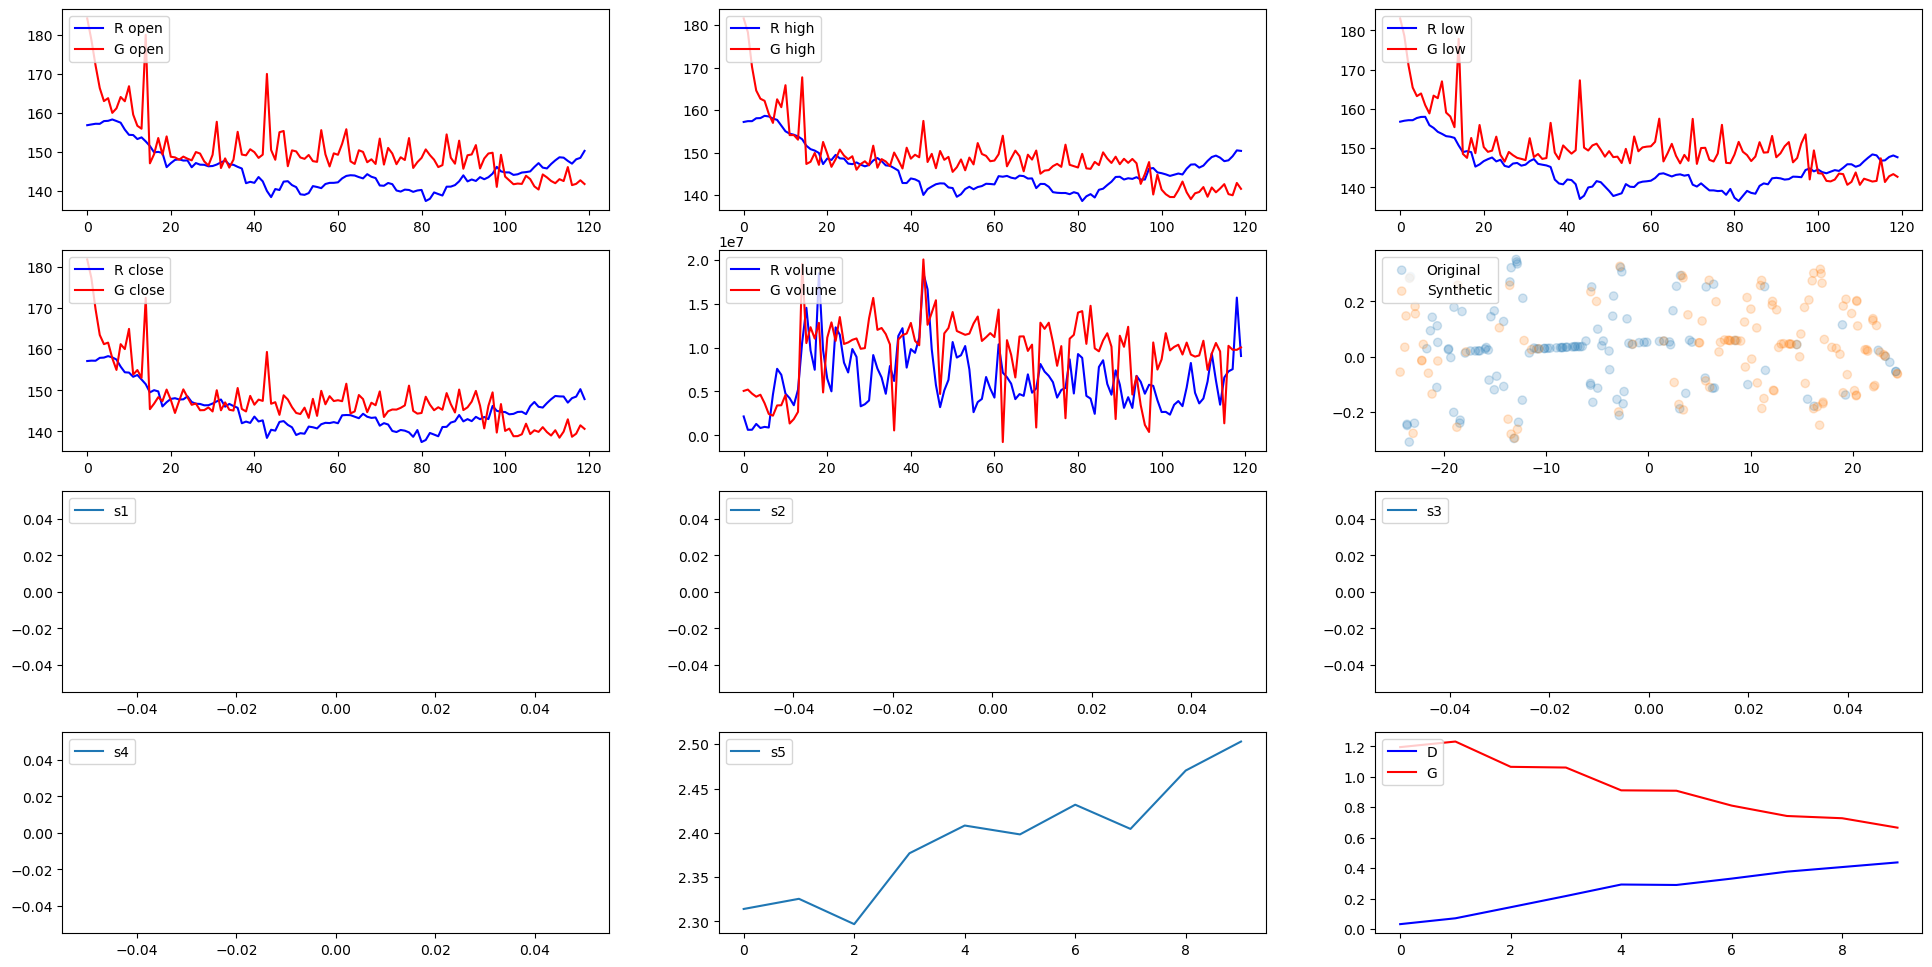

Stage: 5, epoch: 11, loss: 2.560, loss D: 0.480(r/f: 0.21/0.27)(r/f mean: 0.57/0.46), loss G: 0.628, time: 02:11 min
Stage: 5, epoch: 12, loss: 2.523, loss D: 0.479(r/f: 0.22/0.26)(r/f mean: 0.56/0.46), loss G: 0.601, time: 02:13 min
Stage: 5, epoch: 13, loss: 2.545, loss D: 0.480(r/f: 0.22/0.26)(r/f mean: 0.55/0.46), loss G: 0.564, time: 02:14 min
Stage: 5, epoch: 14, loss: 2.542, loss D: 0.488(r/f: 0.22/0.26)(r/f mean: 0.55/0.47), loss G: 0.552, time: 02:11 min
Stage: 5, epoch: 15, loss: 2.558, loss D: 0.490(r/f: 0.23/0.26)(r/f mean: 0.54/0.48), loss G: 0.524, time: 02:11 min
Stage: 5, epoch: 16, loss: 2.565, loss D: 0.492(r/f: 0.23/0.26)(r/f mean: 0.53/0.48), loss G: 0.520, time: 02:12 min
Stage: 5, epoch: 17, loss: 2.562, loss D: 0.496(r/f: 0.24/0.26)(r/f mean: 0.53/0.48), loss G: 0.531, time: 02:16 min
Stage: 5, epoch: 18, loss: 2.564, loss D: 0.498(r/f: 0.24/0.26)(r/f mean: 0.52/0.48), loss G: 0.508, time: 02:11 min
Stage: 5, epoch: 19, loss: 2.588, loss D: 0.502(r/f: 0.24/0.26)(

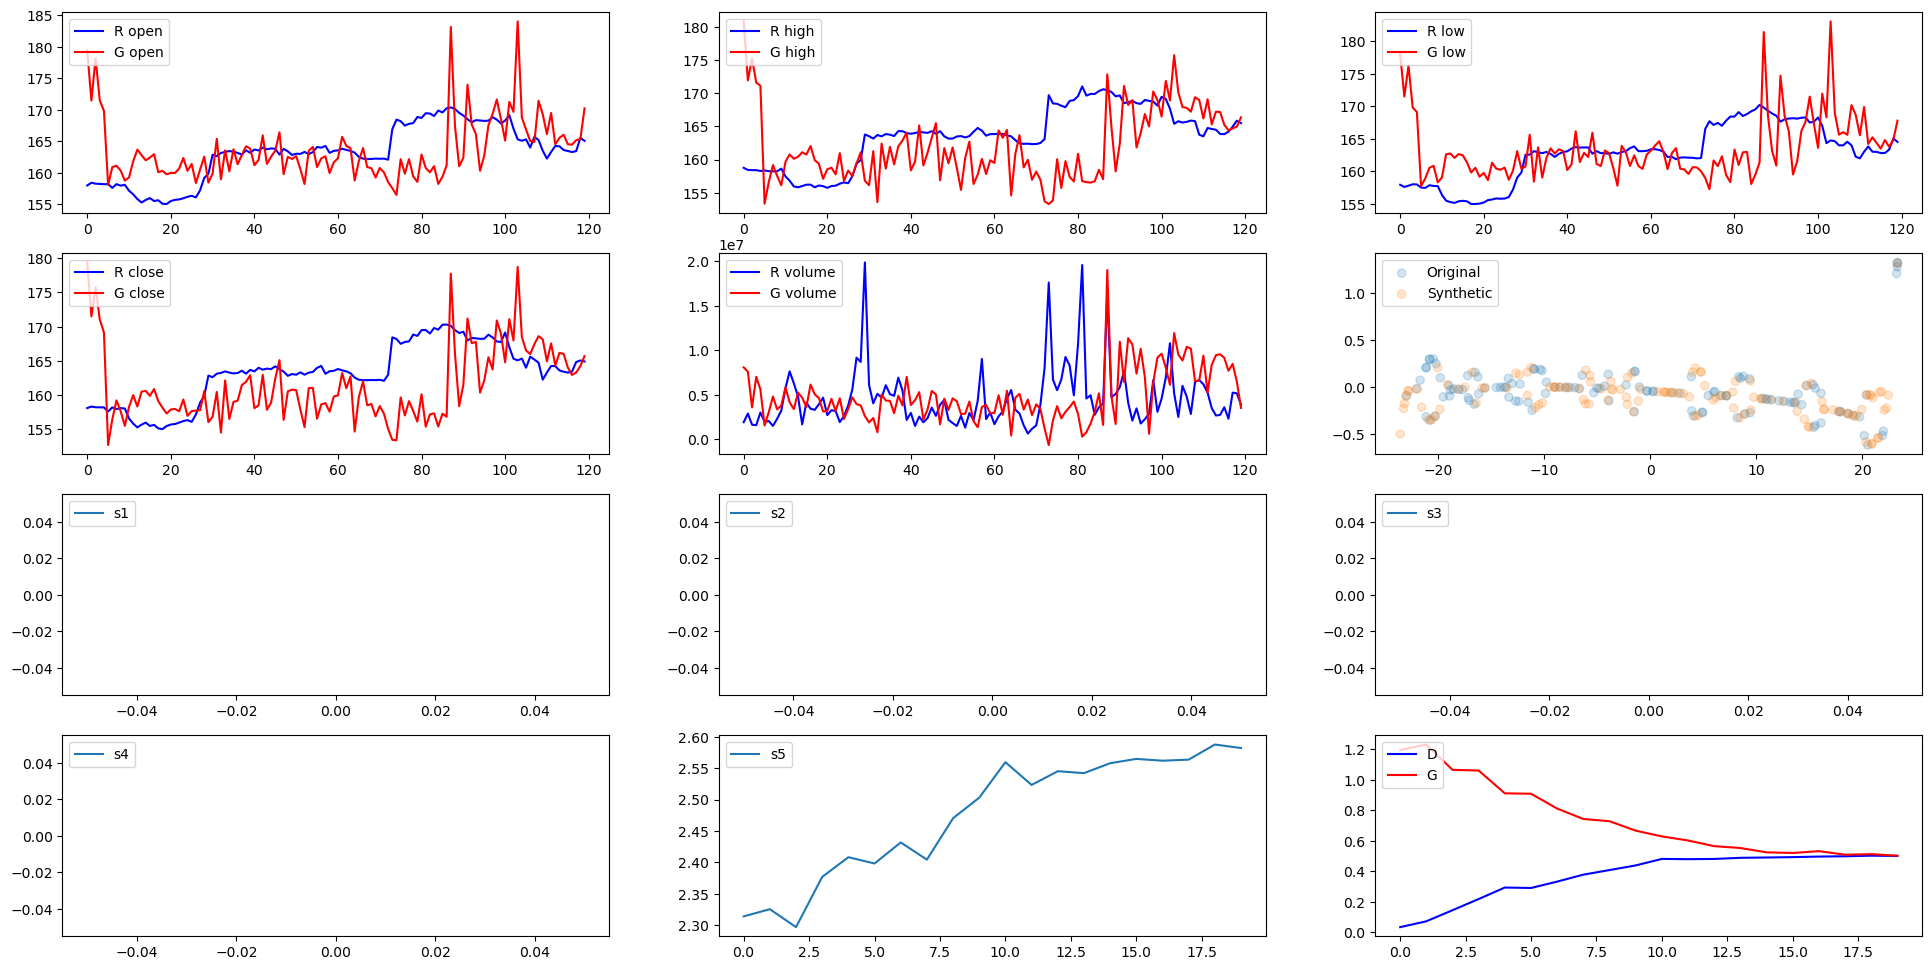

Stage: 5, epoch: 21, loss: 2.589, loss D: 0.502(r/f: 0.24/0.26)(r/f mean: 0.51/0.49), loss G: 0.505, time: 02:12 min
Stage: 5, epoch: 22, loss: 2.599, loss D: 0.495(r/f: 0.24/0.25)(r/f mean: 0.51/0.48), loss G: 0.493, time: 02:14 min
Stage: 5, epoch: 23, loss: 2.599, loss D: 0.501(r/f: 0.25/0.25)(r/f mean: 0.51/0.49), loss G: 0.480, time: 02:11 min
Stage: 5, epoch: 24, loss: 2.588, loss D: 0.504(r/f: 0.25/0.26)(r/f mean: 0.51/0.49), loss G: 0.490, time: 02:11 min
Stage: 5, epoch: 25, loss: 2.592, loss D: 0.500(r/f: 0.25/0.25)(r/f mean: 0.51/0.49), loss G: 0.487, time: 02:10 min
Stage: 5, epoch: 26, loss: 2.623, loss D: 0.498(r/f: 0.24/0.26)(r/f mean: 0.51/0.49), loss G: 0.494, time: 02:10 min
Stage: 5, epoch: 27, loss: 2.607, loss D: 0.503(r/f: 0.25/0.25)(r/f mean: 0.51/0.49), loss G: 0.493, time: 02:10 min
Stage: 5, epoch: 28, loss: 2.620, loss D: 0.500(r/f: 0.25/0.25)(r/f mean: 0.51/0.49), loss G: 0.492, time: 02:18 min
Stage: 5, epoch: 29, loss: 2.616, loss D: 0.500(r/f: 0.25/0.25)(

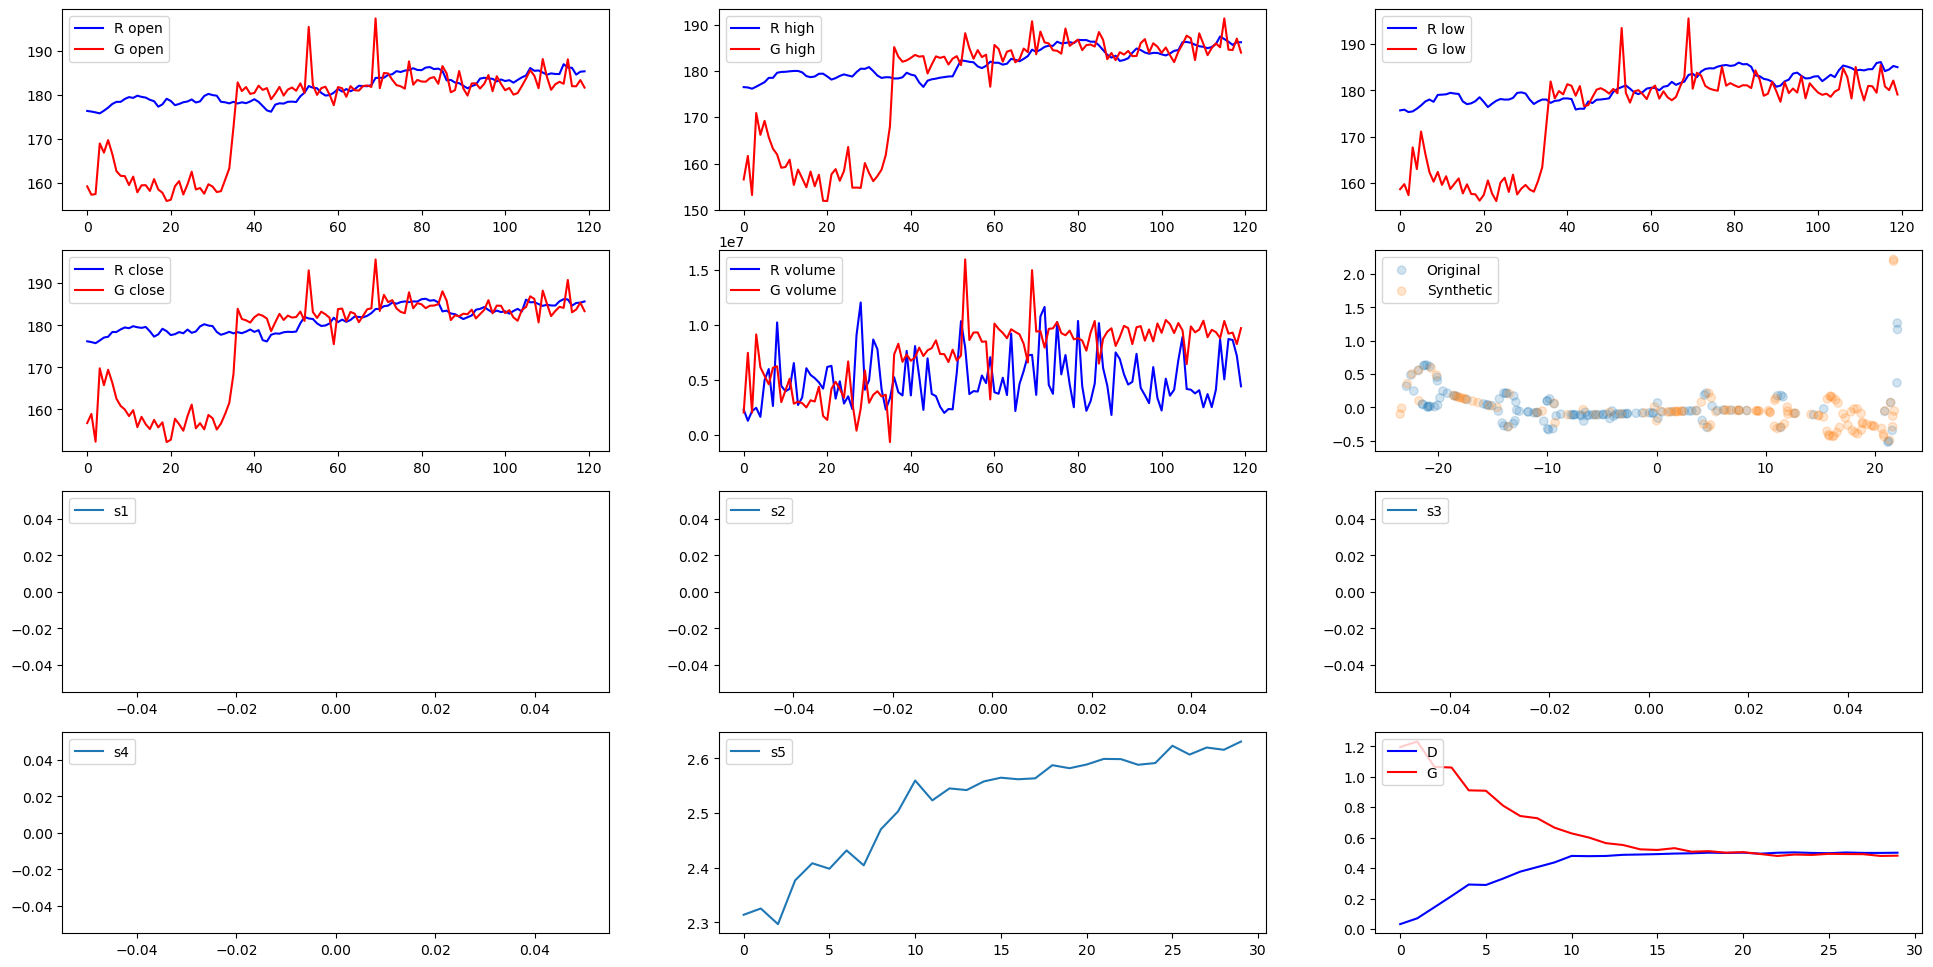

Stage: 5, epoch: 31, loss: 2.632, loss D: 0.503(r/f: 0.25/0.25)(r/f mean: 0.50/0.49), loss G: 0.475, time: 02:17 min
Stage: 5, epoch: 32, loss: 2.592, loss D: 0.505(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.468, time: 02:16 min
Stage: 5, epoch: 33, loss: 2.613, loss D: 0.503(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.491, time: 02:18 min
Stage: 5, epoch: 34, loss: 2.593, loss D: 0.501(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.442, time: 02:20 min
Stage: 5, epoch: 35, loss: 2.598, loss D: 0.505(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.474, time: 02:25 min
Stage: 5, epoch: 36, loss: 2.585, loss D: 0.502(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.454, time: 02:18 min
Stage: 5, epoch: 37, loss: 2.618, loss D: 0.506(r/f: 0.26/0.25)(r/f mean: 0.50/0.50), loss G: 0.474, time: 02:17 min
Stage: 5, epoch: 38, loss: 2.591, loss D: 0.500(r/f: 0.25/0.25)(r/f mean: 0.50/0.49), loss G: 0.459, time: 02:13 min
Stage: 5, epoch: 39, loss: 2.588, loss D: 0.502(r/f: 0.25/0.25)(

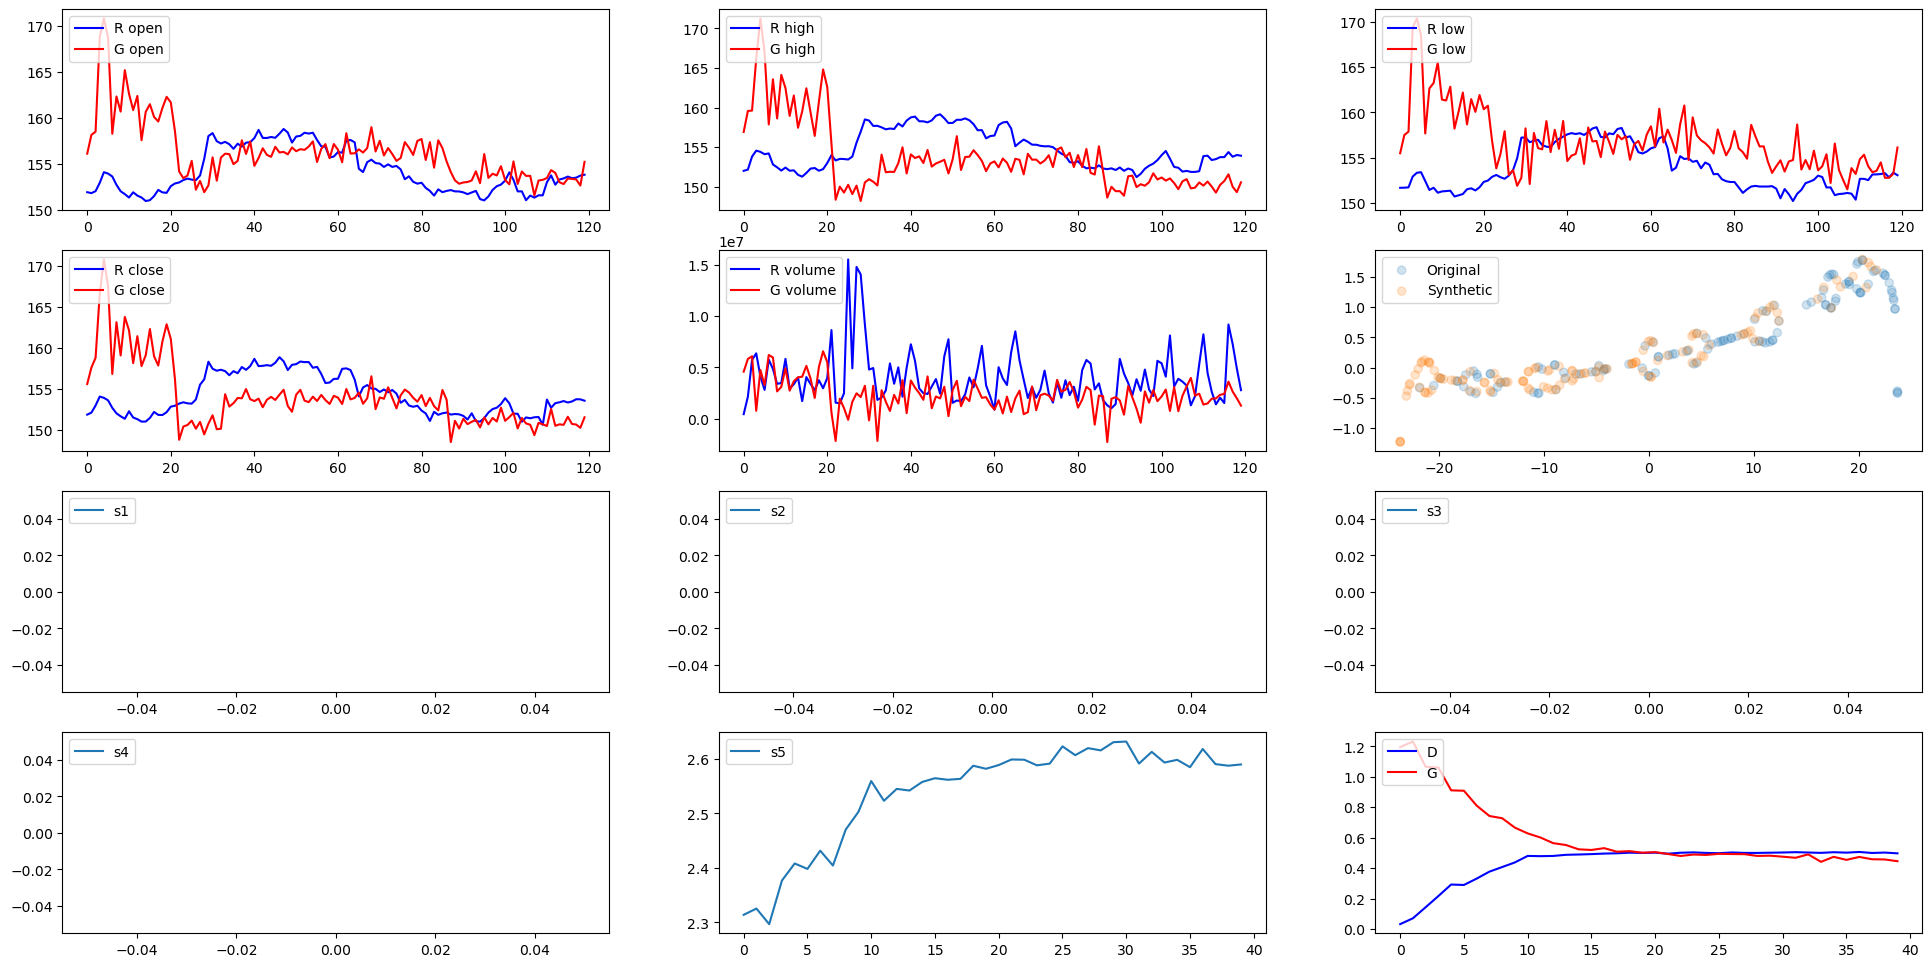

Stage: 5, epoch: 41, loss: 2.582, loss D: 0.501(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.439, time: 02:13 min
Stage: 5, epoch: 42, loss: 2.582, loss D: 0.498(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.444, time: 02:16 min
Stage: 5, epoch: 43, loss: 2.579, loss D: 0.502(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.457, time: 02:13 min
Stage: 5, epoch: 44, loss: 2.567, loss D: 0.498(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.431, time: 02:12 min
Stage: 5, epoch: 45, loss: 2.568, loss D: 0.501(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.436, time: 02:13 min
Stage: 5, epoch: 46, loss: 2.572, loss D: 0.499(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.438, time: 02:15 min
Stage: 5, epoch: 47, loss: 2.568, loss D: 0.502(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.425, time: 02:15 min
Stage: 5, epoch: 48, loss: 2.579, loss D: 0.499(r/f: 0.25/0.25)(r/f mean: 0.50/0.49), loss G: 0.432, time: 02:12 min
Stage: 5, epoch: 49, loss: 2.565, loss D: 0.502(r/f: 0.25/0.25)(

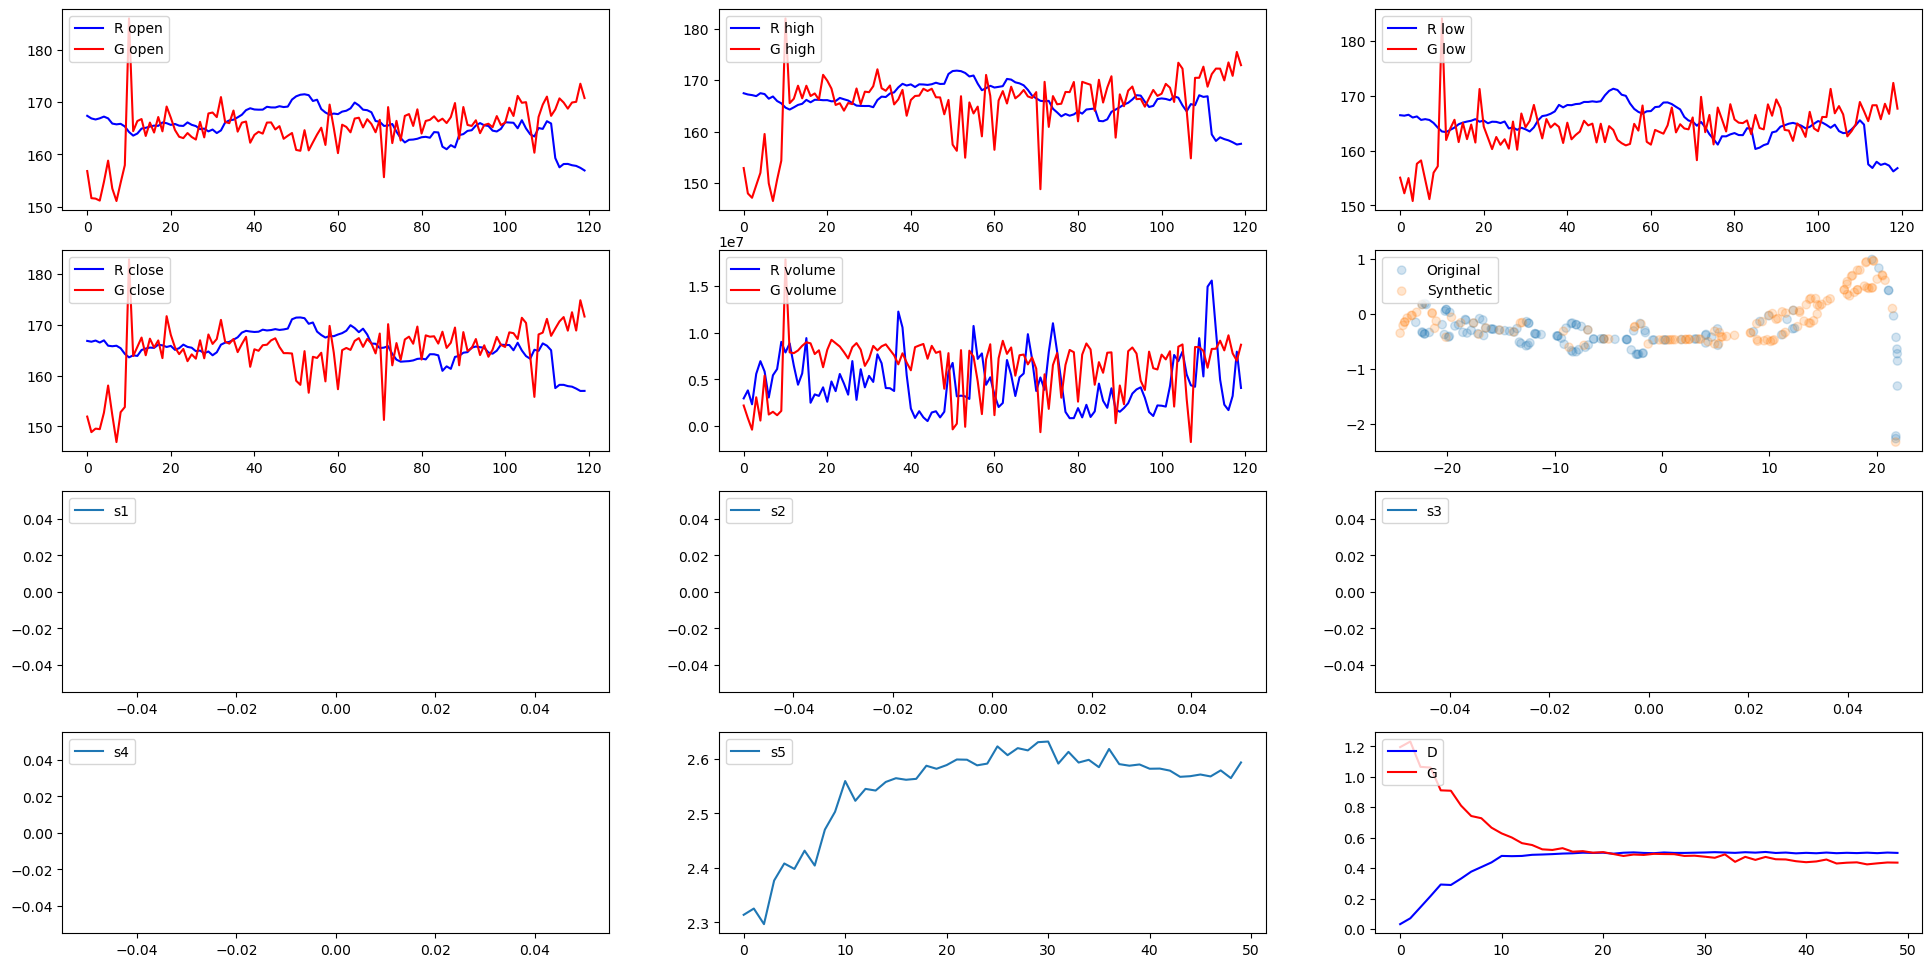

Stage: 5, epoch: 51, loss: 2.589, loss D: 0.502(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.427, time: 02:16 min
Stage: 5, epoch: 52, loss: 2.607, loss D: 0.505(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.467, time: 02:16 min
Stage: 5, epoch: 53, loss: 2.606, loss D: 0.502(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.448, time: 02:14 min
Stage: 5, epoch: 54, loss: 2.607, loss D: 0.503(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.462, time: 02:16 min
Stage: 5, epoch: 55, loss: 2.598, loss D: 0.503(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.446, time: 02:13 min
Stage: 5, epoch: 56, loss: 2.558, loss D: 0.505(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.440, time: 02:18 min
Stage: 5, epoch: 57, loss: 2.567, loss D: 0.504(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.428, time: 02:17 min
Stage: 5, epoch: 58, loss: 2.567, loss D: 0.502(r/f: 0.25/0.25)(r/f mean: 0.50/0.50), loss G: 0.432, time: 02:17 min
Stage: 5, epoch: 59, loss: 2.556, loss D: 0.502(r/f: 0.25/0.25)(

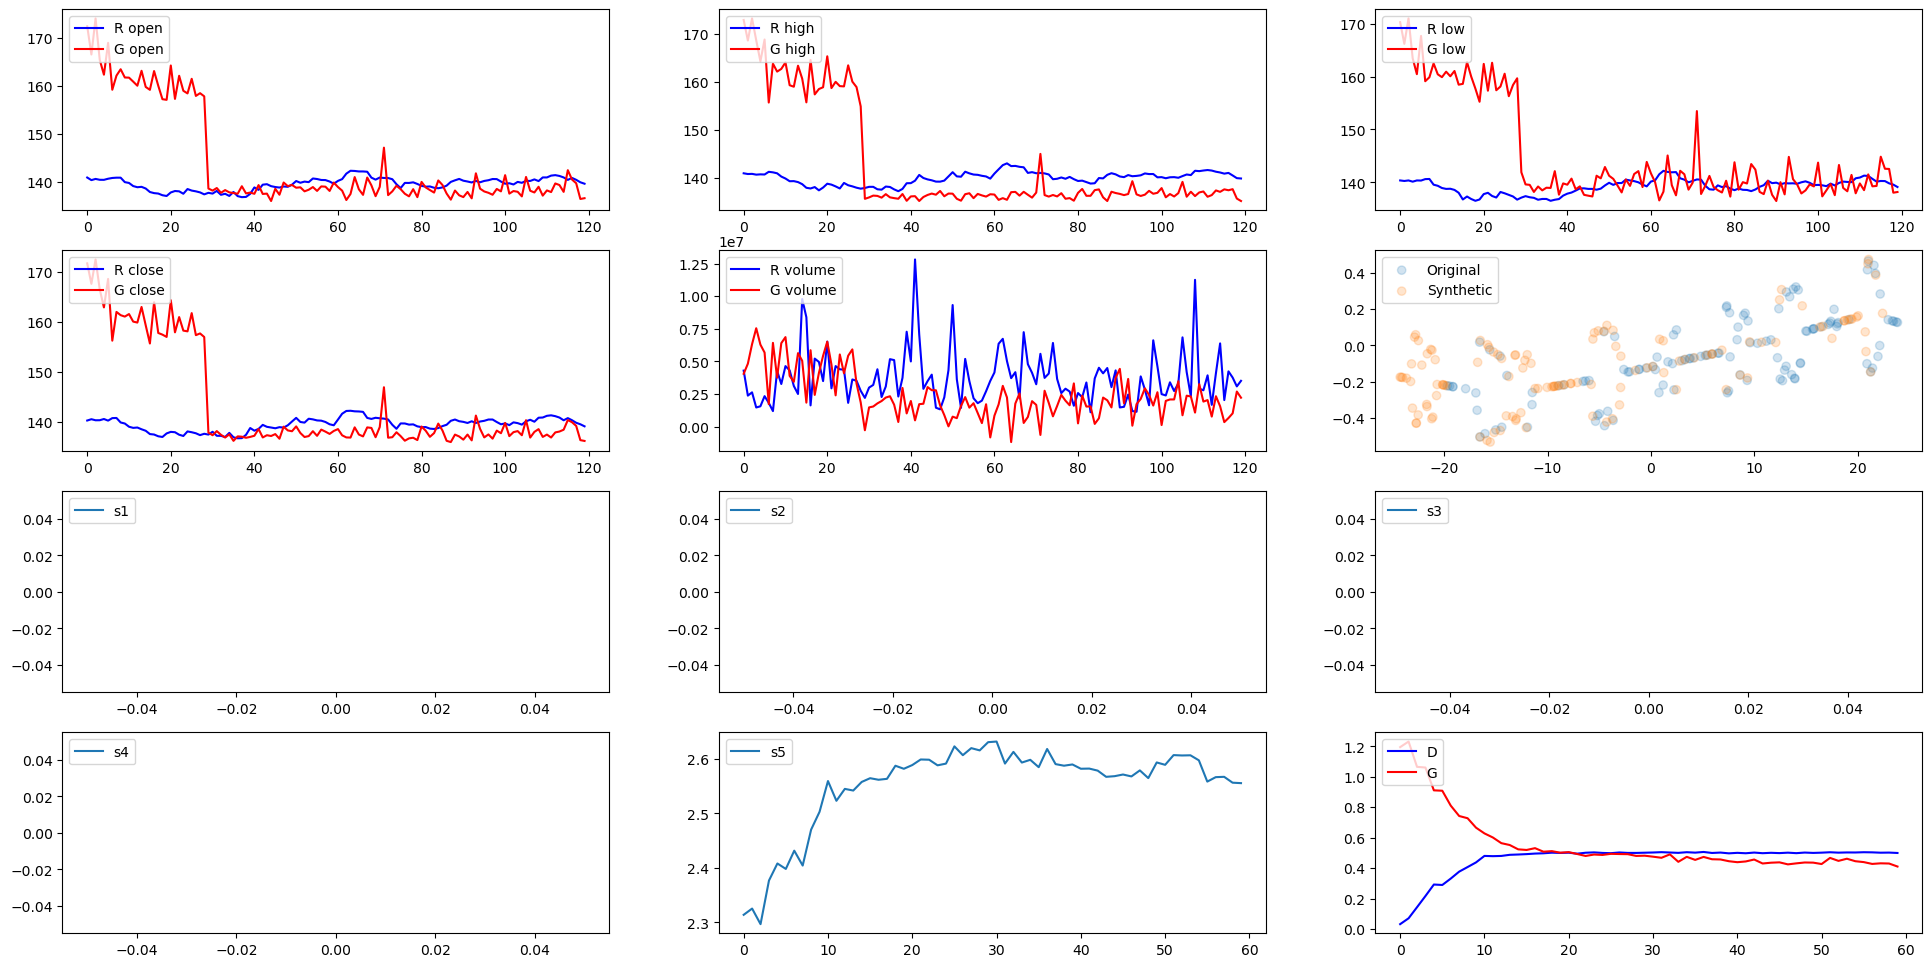

KeyboardInterrupt: 

In [733]:
tst_gan.fit_gan(200, loaders[0][0], scaler, 10)

In [734]:
torch.save(tst_gan.generator.state_dict(), 'generator_s5.mdl')
torch.save(tst_gan.discriminator.state_dict(), 'discriminator_s5.mdl')

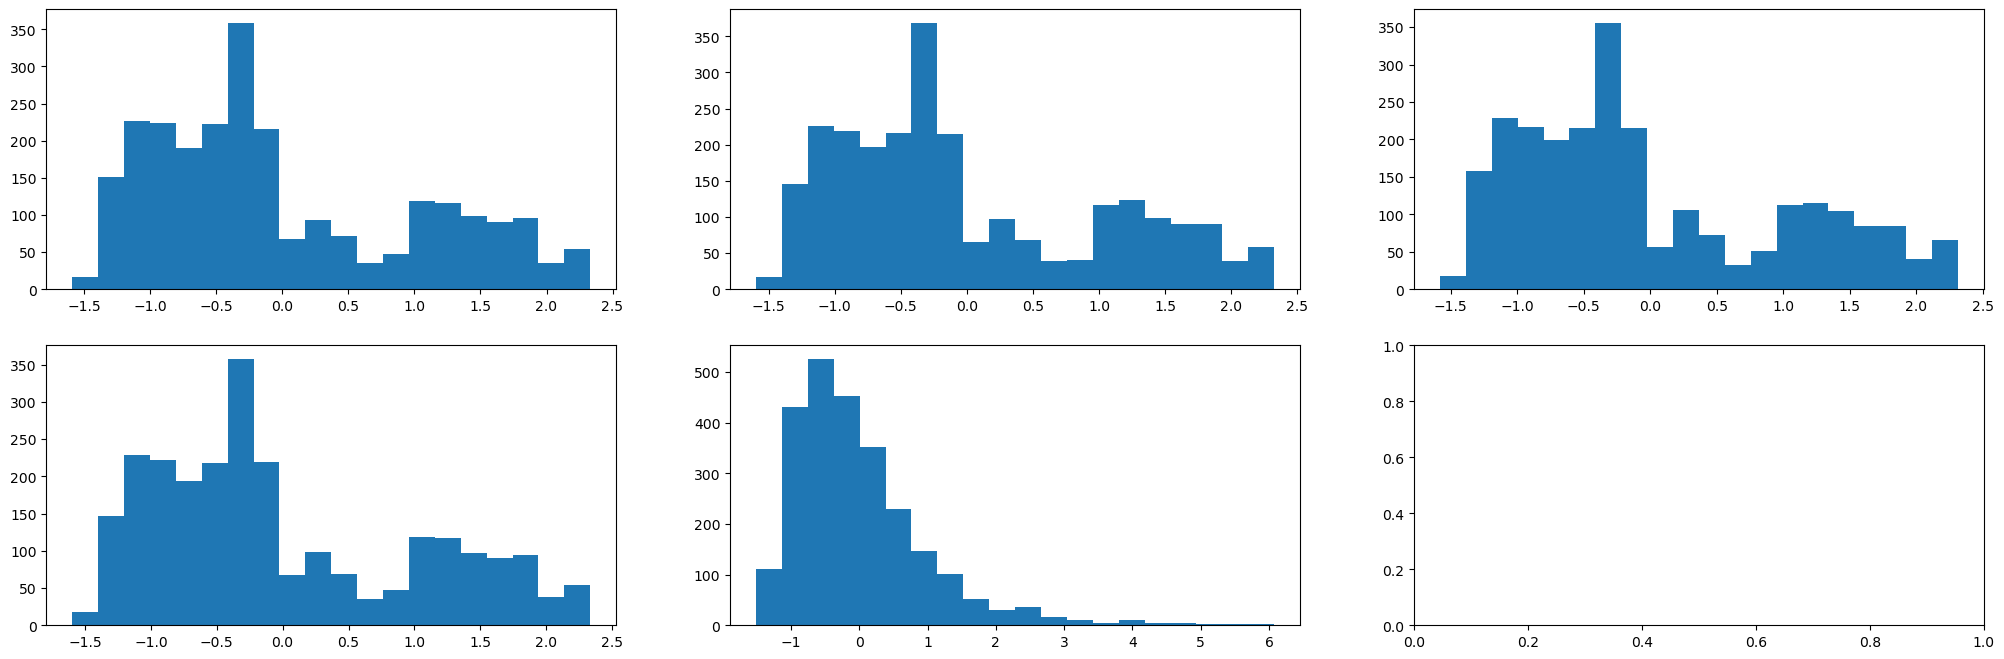

In [556]:
x_real = loaders[0][0].dataset.X

fig, axs = plt.subplots(2, 3, figsize=(25, 8))
axs[0, 0].hist(x_real[:, 0], bins=100)
axs[0, 1].hist(x_real[:, 1], bins=100)
axs[0, 2].hist(x_real[:, 2], bins=100)
axs[1, 0].hist(x_real[:, 3], bins=100)
axs[1, 1].hist(x_real[:, 4], bins=100)
plt.show()
